
To do list:

- Adding edge state and alpha in edge update
- Calculating hG[0] and h_rnn[0] with hg[0] and using them especially for the next rnn state
- GRU and LSTM
- Using (hg[-1],hG[-1]) for the final representation


In [ ]:
%%capture
try:
  already_installed
except:  
    !pip install kora
    !pip install dgl
    !pip install dgl-cu101
    !pip install --pre dgl-cu101
    !pip install dgllife
    # !pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
    # !pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
    # !pip install -q torch-geometric
    !pip install torch_optimizer
    #!pip install pytorch_lightning
    import sys
    import time
    import dgl
    import dgllife
    import torch 
    import pickle
    from IPython.display import clear_output
    import networkx as nx
    import dgl.function as fn
    import torch.nn.functional as F
    import torch.nn as nn
    sys.path.append('/usr/local/lib/python3.6/dist-packages/') # For using RDKit utilizing KORA
    import kora.install.rdkit
    from rdkit import Chem
    from rdkit.Chem import Descriptors
    from rdkit.Chem.Draw import IPythonConsole
    from rdkit.Chem import ChemicalFeatures
    from rdkit import RDConfig
    from dgllife.utils import featurizers as fs
    from torch.utils.data import DataLoader
    import networkx as nx
    import matplotlib.pyplot as plt
    import torch_optimizer as optim
    # import pytorch_lightning as pl  
    # from pytorch_lightning.metrics.classification import AUROC
    # from pytorch_lightning.metrics.classification import AveragePrecision
    # from pytorch_lightning.metrics.classification import Recall
    # from pytorch_lightning.metrics.classification import Precision
    # from pytorch_lightning.metrics.classification import ConfusionMatrix
    from sklearn.metrics import roc_auc_score
    from sklearn.model_selection import train_test_split
    import pandas as pd
    import numpy as np
    import itertools
    import os
    %matplotlib inline
    import warnings
    warnings.filterwarnings("ignore")
    # Fix Seeds
    # Set a seed value
    seed_value= 213 
    # 1. Set `PYTHONHASHSEED` environment variable at a fixed value
    os.environ['PYTHONHASHSEED']=str(seed_value)
    # 2. Set `python` built-in pseudo-random generator at a fixed value
    import random 
    random.seed(seed_value)
    # 3. Set `numpy` pseudo-random generator at a fixed value
    np.random.seed(seed_value)
    # 4. Set `pytorch` pseudo-random generator at a fixed value
    torch.manual_seed(seed_value)
    # 5. Set `dgl` pseudo-random generator at a fixed value
    dgl.seed(seed_value)
    # 6. For layers that introduce randomness like dropout, make sure to set seed values 
    # model.add(Dropout(0.25, seed=seed_value))
    already_installed=True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Data Generation 

def bond_is_in_ring_list_one_hot(bond, allowable_set=None, encode_unknown=False):
          list = [3,4,5] # List denotes the size of cycles
          return [bond.IsInRing()]+[bond.IsInRingSize(i) for i in list]

class CanonicalBondFeaturizer(fs.BaseBondFeaturizer):
       def __init__(self, bond_data_field='e', self_loop=False):
        super(CanonicalBondFeaturizer, self).__init__(
            featurizer_funcs={bond_data_field: fs.ConcatFeaturizer(
                [fs.bond_type_one_hot,
                 fs.bond_is_conjugated,
                 fs.bond_is_in_ring,
                 fs.bond_stereo_one_hot,
                 fs.bond_direction_one_hot,
                 bond_is_in_ring_list_one_hot
                 ]
            )}, self_loop=self_loop)
        
CanonicalBondFeaturizer = CanonicalBondFeaturizer()

# Tox21_dataset = pd.read_csv('https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/tox21.csv.gz', compression='gzip').fillna(0)

# Edge_features=[]
# no_edge=[]
# for i in range(Tox21_dataset.smiles.size):
#   try:
#     Edge_features.append(CanonicalBondFeaturizer(Chem.MolFromSmiles(Tox21_dataset.smiles[i]))['e'])
#   except:
#     no_edge.append(i)
#     Edge_features.append('no_edge')

# Tox21_dataset.drop(no_edge, inplace=True)

# for i in range(len(no_edge)):
#   del Edge_features[no_edge[i]-i]

# %cd /content/

# if not os.path.exists("/content/tox21-global-cdf-rdkit.csv"):
#   !unzip '/content/drive/MyDrive/GMLG_Research/Tox_21_Final/tox21-global-cdf-rdkit.zip'
#   !unzip '/content/drive/MyDrive/GMLG_Research/Tox_21_Final/Node_features_AF_NOH.zip'

# global_fetures = torch.Tensor(pd.read_csv('tox21-global-cdf-rdkit.csv').iloc[:,1:].values)
# with open('Node_features_AF_NOH.pickle', 'rb') as handle:
#     Node_features = pickle.load(handle)
1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.# for i in range(len(no_edge)):
#   del Node_features[no_edge[i]-i]

# for i in range(len(no_edge)):
#   global_fetures = global_fetures [torch.arange(global_fetures.size (0))!= no_edge[i] - i]

class DGLDatasetTox(torch.utils.data.Dataset):

    def __init__(self):

        Tox21_dataset = pd.read_csv('https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/tox21.csv.gz', compression='gzip').fillna(0)
        
        Edge_features=[]
        no_edge=[]
        for i in range(Tox21_dataset.smiles.size):
          try:
            Edge_features.append(CanonicalBondFeaturizer(Chem.MolFromSmiles(Tox21_dataset.smiles[i]))['e'])
          except:
            no_edge.append(i)
            Edge_features.append('no_edge')

        Tox21_dataset.drop(no_edge, inplace=True)

        for i in range(len(no_edge)):
          del Edge_features[no_edge[i]-i]

        %cd /content/

        if not os.path.exists("/content/tox21-global-cdf-rdkit.csv"):
          !unzip '/content/drive/MyDrive/GMLG_Research/Tox_21_Final/tox21-global-cdf-rdkit.zip'
          !unzip '/content/drive/MyDrive/GMLG_Research/Tox_21_Final/Node_Features_AF3_NOH.zip'

        #global_fetures = torch.Tensor(pd.read_csv('tox21-global-cdf-rdkit.csv').fillna(0).iloc[:,1:].values) # 101 NaN: should be addrressed correctly
        gf_df = pd.read_csv('tox21-global-cdf-rdkit.csv')
        global_fetures = torch.Tensor(gf_df.fillna(gf_df.mean()).iloc[:,1:].values) # 101 NaN; fill mean

        with open('Node_Features_AF3_NOH.pickle', 'rb') as handle:
            Node_features = pickle.load(handle)
        Node_features[1910][1][-3] = 1.1 # problem with the atom
        for i in range(len(no_edge)):
          del Node_features[no_edge[i]-i]

        for i in range(len(no_edge)):
          global_fetures = global_fetures [torch.arange(global_fetures.size (0))!= no_edge[i] - i]

        self.dgl_graphs = []
        for i in range(len(Node_features)):
          mol = Chem.MolFromSmiles(Tox21_dataset.iloc[i,-1])
          self.dgl_graphs.append(dgllife.utils.mol_to_bigraph(mol, canonical_atom_order=False))
          self.dgl_graphs[i].ndata['h_0'] = Node_features[i]
          self.dgl_graphs[i].edata['e_0'] = Edge_features[i]

        self.smiles = []
        for o in range(len(self.dgl_graphs)):
          self.smiles.append(Tox21_dataset.iloc[o,13])
          
        self.global_fetures = global_fetures
        self.labels = Tox21_dataset.iloc[:,:12].values
        self.masks = Tox21_dataset.replace({0: 1}).iloc[:,:12].values        
        
        # # Unzip the dataset and read its csv file, and fill in NaN values with 0
        # self.csv = pd.read_csv(csv_url, compression='gzip').fillna(0) 

        # # Make masks for labels (0 as NaN value, and 1 as other values)
        # self.masks_csv = pd.read_csv(csv_url, compression='gzip').replace({0: 1}).fillna(0)

        # # Split smiles, labels, and masks columns as lists
        # self.smiles = self.csv.iloc[:,13]
        # self.labels = self.csv.iloc[:,:12].values
        # self.masks = self.masks_csv.iloc[:,:12].values 

    def __len__(self):
        return len(self.dgl_graphs)

    def __getitem__(self, idx):
        return  self.smiles[idx], self.dgl_graphs[idx], self.global_fetures[idx], torch.Tensor(self.labels[idx]), torch.Tensor(self.masks[idx])
        
dataset = DGLDatasetTox()

# Train, validation, and test set split
train_set, val_set, test_set = dgllife.utils.ScaffoldSplitter.train_val_test_split(dataset, frac_val=0.1, frac_test=0.1)

def collate(batch):
    # batch is a list of triples (graphs, labels, masks)
    # Concatenate a sequence of graphs
    
    smiles = [e[0] for e in batch]
    
    graphs = [e[1] for e in batch]
    g = dgl.batch(graphs)

    gf = [e[2] for e in batch]
    gf = torch.stack(gf, 0)

    # Concatenate a sequence of tensors (labels) along a new dimension
    labels = [e[3] for e in batch]
    labels = torch.stack(labels, 0)

    # Concatenate a sequence of tensors (masks) along a new dimension
    masks = [e[4] for e in batch]
    masks = torch.stack(masks, 0)

    return smiles, g, gf, labels, masks

def loader(batch_size=64):

    train_dataloader = DataLoader(train_set,
                              batch_size=batch_size,
                              collate_fn=collate,
                              drop_last=False,
                              shuffle=True)

    val_dataloader =  DataLoader(val_set,
                             batch_size=batch_size,
                             collate_fn=collate,
                             drop_last=False,
                             shuffle=False)

    test_dataloader = DataLoader(test_set,
                             batch_size=batch_size,
                             collate_fn=collate,
                             drop_last=False,
                             shuffle=False)
    
    return train_dataloader, val_dataloader, test_dataloader

# borrowed form: https://stackoverflow.com/a/62508086
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
#count_parameters(model)

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

def my_loss(output, label, mask=None):
    criterion = nn.BCELoss(reduction='none')
    if mask == None:
        loss = torch.sum(torch.mean(criterion(output,label), axis=1))
    else: 
        loss = torch.sum(torch.mean(mask*criterion(output,label), axis=1))
    return loss 

def train_model(model, batch_size, optimizer, patience=10, n_epochs=1):
    #metric=AUROC()
    metric = roc_auc_score
    train_dataloader, val_dataloader, test_dataloader  = loader(batch_size)
    train_losses = []
    val_losses = []
    early_stopping = EarlyStopping(patience=patience, verbose=True) # initialize the early_stopping object
    start_time = time.time()
    #optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(1, n_epochs+1):
        epoch_train_loss = 0
        epoch_val_loss = 0
        
        model.train() #Prepare model for training
        for i, (_, mol_dgl_graph, fg, labels, masks) in enumerate(train_dataloader):
            mol_dgl_graph=mol_dgl_graph.to(device)
            labels=labels.to(device)
            masks=masks.to(device)
            fg=fg.to(device)
            prediction = model(mol_dgl_graph, fg)
            loss_train = my_loss(prediction, labels, masks)
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()
            epoch_train_loss += loss_train.detach().item()
        epoch_train_loss /= (len(train_set))
        train_losses.append(epoch_train_loss)

        model.eval() #Prepare model for evaluation
        for i, (_, mol_dgl_graph, fg, labels, masks) in enumerate(val_dataloader):
              mol_dgl_graph=mol_dgl_graph.to(device)
              labels=labels.to(device)
              masks=masks.to(device)
              fg=fg.to(device)
              prediction = model(mol_dgl_graph, fg)
              loss_val = my_loss(prediction, labels, masks)
              epoch_val_loss += loss_val.detach().item()
        epoch_val_loss /= (len(val_set))
        epoch_len = len(str(n_epochs))
        clear_output()
        print(f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {epoch_train_loss:.5f} ' +
                     f'valid_loss: {epoch_val_loss:.5f}')
        '''
        early_stopping needs the validation loss to check if it has decreased, 
        and if it has, it will make a checkpoint of the current model
        '''
        early_stopping(epoch_val_loss, model)
        val_losses.append(epoch_val_loss)
        if early_stopping.early_stop:
            print("Early Stopping")
            break

    print('\n Training Time was', time.time()-start_time, 'seconds in', device)
    model.load_state_dict(torch.load('checkpoint.pt')) #loading the last checkpoint with the best model

    print('\n')
    
    
    ##Learning Curve
    plt.figure(figsize=(7,5))
    plt.figure(figsize=(7,5))
    # Draw lines
    plt.plot(range(len(train_losses)), train_losses, '--', color="red",  label="Train loss")
    plt.plot(range(len(val_losses)), val_losses, color="green", label="Validation loss")
    # Create plot
    plt.title("Learning Curve")
    plt.xlabel("Epoch"), plt.ylabel("Cross entropy loss"), plt.legend(loc="best")
    plt.show()
 
    with torch.no_grad():
        iter = 0
        prediction_all= torch.empty(0, device=device)
        labels_all= torch.empty(0, device=device)
        masks_all= torch.empty(0, device=device)
        for i, (_, mol_dgl_graph, fg, labels, masks) in enumerate(test_dataloader):
            mol_dgl_graph=mol_dgl_graph.to(device)
            labels=labels.to(device)
            masks=masks.to(device)
            fg=fg.to(device)
            prediction = model(mol_dgl_graph, fg)
            prediction_all = torch.cat((prediction_all, prediction), 0)
            labels_all = torch.cat((labels_all, labels), 0)
            masks_all = torch.cat((masks_all, labels), 0)
        average = torch.tensor([0.], device=device)
        for i in range(12):
          #average += metric(prediction_all[:, i].view(-1), labels_all[:, i].view(-1).int()) with pytorch-lightening
          average += metric(labels_all[:, i].view(-1).int().to('cpu'), prediction_all[:, i].view(-1).to('cpu')) 
    print('\n Test AUC is', average.item()/12)

    return  model, train_losses, val_losses 

RDKit WARNING: [06:56:24] WARNING: not removing hydrogen atom without neighbors


/content


RDKit WARNING: [06:56:30] WARNING: not removing hydrogen atom without neighbors


Start initializing RDKit molecule instances...
Creating RDKit molecule instance 1000/7812


RDKit WARNING: [06:56:38] WARNING: not removing hydrogen atom without neighbors


Creating RDKit molecule instance 2000/7812
Creating RDKit molecule instance 3000/7812
Creating RDKit molecule instance 4000/7812
Creating RDKit molecule instance 5000/7812
Creating RDKit molecule instance 6000/7812
Creating RDKit molecule instance 7000/7812
Start computing Bemis-Murcko scaffolds.
Computing Bemis-Murcko for compound 1000/7812
Computing Bemis-Murcko for compound 2000/7812
Computing Bemis-Murcko for compound 3000/7812
Computing Bemis-Murcko for compound 4000/7812
Computing Bemis-Murcko for compound 5000/7812
Computing Bemis-Murcko for compound 6000/7812
Computing Bemis-Murcko for compound 7000/7812


In [ ]:
%%capture
if torch.cuda.is_available():  
  device = "cuda:0" 
else:  
  device = "cpu" 

  
class GGNN(nn.Module):
 
    def __init__(self, feat_v_dim, feat_e_dim, feat_g_dim, state_v_dim, state_e_dim, state_g_dim, hidden_e_dim, hidden_m_dim, message_dim, hidden_v_dim, hidden_r_dim, rep_dim, rnn_layers, hidden1_alpha_dim, hidden2_alpha_dim, rnn_initial_state='Random', act1="selu", act2="selu", act3="selu", act4="selu", act5="selu", act6='tanh', act7="selu", num_layers=5):
        super().__init__()
        self.feat_v_dim = feat_v_dim
        self.feat_e_dim = feat_e_dim
        self.feat_g_dim = feat_g_dim
        self.state_v_dim = state_v_dim
        self.state_e_dim = state_e_dim
        self.state_g_dim = state_g_dim
        self.hidden_e_dim = hidden_e_dim
        self.hidden_m_dim = hidden_m_dim
        self.m_dim = message_dim
        self.hidden_v_dim = hidden_v_dim
        self.hidden_r_dim = hidden_r_dim
        self.rep_dim = rep_dim
        self.hidden1_alpha_dim = hidden1_alpha_dim
        self.hidden2_alpha_dim = hidden2_alpha_dim
        self.num_layers = num_layers
        self.rnn_layers = rnn_layers 

        self.act1 = eval("torch.nn.functional."+act1)
        self.act2 = eval("torch.nn.functional."+act2)
        self.act3 = eval("torch.nn.functional."+act3)
        self.act4 = eval("torch.nn.functional."+act4)
        self.act5 = eval("torch.nn.functional."+act5)
        self.act6 = act6
        self.act7 = eval("torch.nn.functional."+act7)

        # All linear layers have bias except the message function, for having zero message when input is zero (removed) 
        self.linear_0_v = nn.Linear(self.feat_v_dim, self.state_v_dim)
        self.linear_0_e = nn.Linear(self.feat_e_dim, self.state_e_dim)
        self.linear_0_g = nn.Linear(self.feat_g_dim, self.state_g_dim)
        
        self.linear_e_0 = nn.Linear(2*self.state_v_dim + 3*self.state_e_dim + self.state_g_dim, self.hidden_e_dim)
        self.linear_e_1 = nn.Linear(self.hidden_e_dim, self.state_e_dim)

        # Bias = False, for having zero message when input is zero (removed)
        self.linear_m_0 = nn.Linear(self.state_v_dim + self.state_e_dim, self.hidden_m_dim, bias=False) 
        self.linear_m_1 = nn.Linear(self.hidden_m_dim, self.m_dim, bias=False)

        self.linear_v_0 = nn.Linear(self.state_v_dim + 2*self.m_dim, self.hidden_v_dim)
        self.linear_v_1 = nn.Linear(self.hidden_v_dim, self.state_v_dim)

        self.linear_r_0 = nn.Linear(self.state_v_dim + 2*state_e_dim, self.hidden_r_dim)
        self.linear_r_1 = nn.Linear(self.hidden_r_dim, self.state_g_dim)

        self.rnn = nn.RNN(self.state_g_dim, self.rep_dim, self.rnn_layers, nonlinearity=self.act6)
        if rnn_initial_state == 'Random':
          self.rnn_initial_state = torch.randn(self.rnn_layers, self.rep_dim).to(device)
        else:
          self.rnn_initial_state = rnn_initial_state.to(device)

        self.linear_alpha_0 = nn.Linear(2*self.state_v_dim + 3*state_e_dim + self.state_g_dim + self.rep_dim + 1, self.hidden1_alpha_dim)
        self.linear_alpha_1 = nn.Linear(self.hidden1_alpha_dim, self.hidden2_alpha_dim)
        self.linear_alpha_2 = nn.Linear(self.hidden2_alpha_dim, 1)

        # self.d1 = torch.nn.Dropout(p=0.2) 
        # self.d2 = torch.nn.Dropout(p=0.2) 
        # self.d3 = torch.nn.Dropout(p=0.2)
        # if bias_v:
        #     self.bias_v = torch.nn.Parameter(torch.FloatTensor(out_feat_1))
        # else:
        #     self.register_parameter('bias_v', None) 

        """Reinitialize learnable parameters."""
        gain1 = nn.init.calculate_gain('relu')
        nn.init.xavier_normal_(self.linear_0_v.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_0_e.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_0_g.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_e_0.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_e_1.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_m_0.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_m_1.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_v_0.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_v_1.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_r_0.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_r_1.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_alpha_0.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_alpha_1.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_alpha_2.weight, gain=gain1)

    ################################################################
    def alpha_updater(self,input):

      # It has a depth of 3
      out = self.act7(self.linear_alpha_0(input))
      out = self.act7(self.linear_alpha_1(out))
      out = nn.functional.relu(nn.functional.tanh(self.linear_alpha_2(out)))
      #out = nn.functional.relu(self.linear_alpha_2(out))

      return out

    ################################################################
    def node_reader(self,nodes):

      cat = torch.cat((nodes.data['h'], nodes.data['e_alpha_agg_i'], nodes.data['e_alpha_agg_o']), 1)
      out = self.act5(self.linear_r_0(cat))
      out = self.act5(self.linear_r_1(out))

      return {'r' : out}

    ################################################################
    def node_updater(self,nodes):

      cat = torch.cat((nodes.data['h'], nodes.data['m_agg_i'], nodes.data['m_agg_o']), 1)
      out=self.act4(self.linear_v_0(cat))
      out=self.act4(self.linear_v_1(out))

      return {'h' : out}

    ################################################################
    def edge_message(self,edges):

      cat = torch.cat((edges.src['h'], edges.data['e_alpha']), 1)
      # should not have bias to produce zero output in case of alpha zero 
      out=self.act3(self.linear_m_0(cat))
      out=self.act3(self.linear_m_1(out))

      return {'message' : out}

    ################################################################
    def edge_updater(self,input):

      out=self.act2(self.linear_e_0(input))
      out=self.act2(self.linear_e_1(out))

      return out

    ################################################################
    def edges_cat(self, edges):

      #cat = torch.cat((edges.src["h"], edges.dst["h"], edges.src["e_alpha_agg_i"], edges.dst["e_alpha_agg_o"]), 1) # Apparently false
      cat = torch.cat((edges.data['e'], edges.src["h"], edges.src["e_alpha_agg_i"], edges.dst["h"], edges.dst["e_alpha_agg_o"]), 1)

      return {'cat' : cat}

    ################################################################
    ################    Forward      ###################

    def forward(self, mol_dgl_graph, fg):

      # Initialization of the model
      hg=torch.empty(0, device=device)
      hG=torch.empty(0, device=device)
      alpha=torch.empty(0, device=device)
      alpha=torch.cat((alpha, torch.ones(mol_dgl_graph.number_of_edges(), dtype=torch.float, device=device).view(1,-1)), 0)
      mol_dgl_graph_ub = dgl.unbatch(mol_dgl_graph)
      len_batch = len(mol_dgl_graph_ub)
      num_edges_ub = [mol_dgl_graph_ub[i].number_of_edges() for i in range(len_batch)] # dose not take time
      
      # RNN in Pytorch
      # input of shape (seq_len, batch, input_size) 
      # h_0 of shape (num_layers * num_directions, batch, hidden_size)
      # output of shape (seq_len, batch, num_directions * hidden_size)
      # h_n of shape (num_layers * num_directions, batch, hidden_size)
      h_rnn=[]
      h_rnn.append(self.rnn_initial_state.repeat(1, len_batch).view(self.rnn_layers, len_batch, -1)) # -1 : self.rep_dim
      
      # Initial global state
      hg = torch.cat((hg, self.act1(self.linear_0_g(fg)).view(1, len_batch,-1)), 0)
      # hg_0 = self.act1(self.linear_0_g(fg))

      with mol_dgl_graph.local_scope():

        # Initial edge and node states
        mol_dgl_graph.edata['e'] = self.act1(self.linear_0_e(mol_dgl_graph.edata["e_0"]))
        mol_dgl_graph.ndata['h'] = self.act1(self.linear_0_v(mol_dgl_graph.ndata["h_0"]))

        # Loop on layers
        for i in range(self.num_layers):
          
          # multiplying edge states by alpha and their aggregation
          mol_dgl_graph.edata['e_alpha'] = torch.mul(mol_dgl_graph.edata['e'], alpha[i].view(-1,1))
          mol_dgl_graph.update_all(fn.copy_edge('e_alpha','m_e_alpha_i'), fn.sum('m_e_alpha_i','e_alpha_agg_i'))
          mol_dgl_graph_rev = dgl.reverse(mol_dgl_graph, copy_edata=True)
          mol_dgl_graph_rev.update_all(fn.copy_edge('e_alpha','m_e_alpha_o'), fn.sum('m_e_alpha_o','e_alpha_agg_o_buffer'))
          mol_dgl_graph.ndata['e_alpha_agg_o'] = mol_dgl_graph_rev.ndata['e_alpha_agg_o_buffer']

          # updating edges
          mol_dgl_graph.apply_edges(self.edges_cat)
          global_states=torch.empty(0, device=device)
          for j in range(len_batch): # dose not take a long time; it's in the order of a few ms (tested!)
            global_states=torch.cat((global_states, hg[i][j].repeat(num_edges_ub[j], 1)), 0)
          mol_dgl_graph.edata['e_bu'] = torch.cat((mol_dgl_graph.edata['cat'], global_states), 1) # Bu: before updating
          mol_dgl_graph.edata['e'] = self.edge_updater(mol_dgl_graph.edata['e_bu']) # applying the NN function for updating edges

          # multiplying the new edge states by alpha and their aggregation
          mol_dgl_graph.edata['e_alpha'] = torch.mul(mol_dgl_graph.edata['e'], alpha[i].view(-1,1))
          mol_dgl_graph.update_all(fn.copy_edge('e_alpha','m_e_alpha_i'), fn.sum('m_e_alpha_i','e_alpha_agg_i'))
          mol_dgl_graph_rev = dgl.reverse(mol_dgl_graph, copy_edata=True)
          mol_dgl_graph_rev.update_all(fn.copy_edge('e_alpha','m_e_alpha_o'), fn.sum('m_e_alpha_o','e_alpha_agg_o_buffer'))
          mol_dgl_graph.ndata['e_alpha_agg_o'] = mol_dgl_graph_rev.ndata['e_alpha_agg_o_buffer']

          # calculating edge messages
          mol_dgl_graph.apply_edges(self.edge_message)
          
          # aggregating messages
          mol_dgl_graph.update_all(fn.copy_edge('message','m_i'), fn.sum('m_i','m_agg_i'))
          mol_dgl_graph_rev = dgl.reverse(mol_dgl_graph, copy_edata=True)
          mol_dgl_graph_rev.update_all(fn.copy_edge('message','m_o'), fn.sum('m_o','m_agg_o_buffer'))
          mol_dgl_graph.ndata['m_agg_o'] = mol_dgl_graph_rev.ndata['m_agg_o_buffer']

          # updating nodes
          mol_dgl_graph.apply_nodes(self.node_updater)

          # reading each node in graph with its incoming and outgoing edges
          mol_dgl_graph.apply_nodes(self.node_reader)

          # representation in this layer: aggregating r from all nodes
          hg = torch.cat((hg, dgl.sum_nodes(mol_dgl_graph, 'r').view(1, len_batch,-1)),0)

          # molecular representation untill this layer
          hG_buffer, h_rnn_buffer = self.rnn(hg[i+1].view(1, len_batch, -1), h_rnn[i])
          hG = torch.cat((hG, hG_buffer),0) # hG_buffer dosen't need reshaping as its shape is (1, len_batch, -1)
          h_rnn.append(h_rnn_buffer)

          # calculating next layer's alphas
          mol_dgl_graph.apply_edges(self.edges_cat)
          global_rep = torch.empty(0, device=device)
          for j in range(len_batch): 
            global_rep = torch.cat((global_rep, torch.cat((hg[i+1][j].repeat(num_edges_ub[j],1), hG[i][j].repeat(num_edges_ub[j],1)), 1)), 0)
          alpha = torch.cat((alpha, self.alpha_updater(torch.cat((mol_dgl_graph.edata['cat'], global_rep, alpha[i].view(-1,1)), 1)).view(1,-1)),0)

        return (hg[-1], h_rnn[-1], alpha) # first must be hG[-1]

[ 59/200] train_loss: 0.15204 valid_loss: 0.17876
EarlyStopping counter: 25 out of 25
Early Stopping

 Training Time was 425.4096796512604 seconds in cpu




<Figure size 504x360 with 0 Axes>

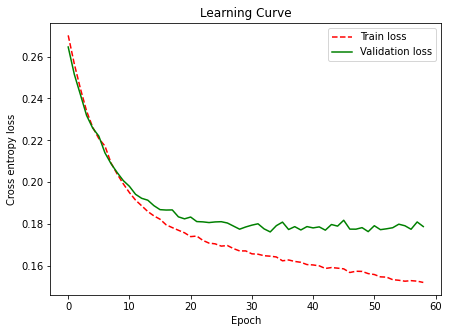


 Test AUC is 0.7799243132273356
+----------------------------+------------+
|          Modules           | Parameters |
+----------------------------+------------+
|   GNN1.linear_0_v.weight   |    580     |
|    GNN1.linear_0_v.bias    |     20     |
|   GNN1.linear_0_e.weight   |    380     |
|    GNN1.linear_0_e.bias    |     20     |
|   GNN1.linear_0_g.weight   |    4000    |
|    GNN1.linear_0_g.bias    |     20     |
|   GNN1.linear_e_0.weight   |    2400    |
|    GNN1.linear_e_0.bias    |     20     |
|   GNN1.linear_e_1.weight   |    400     |
|    GNN1.linear_e_1.bias    |     20     |
|   GNN1.linear_m_0.weight   |    800     |
|   GNN1.linear_m_1.weight   |    400     |
|   GNN1.linear_v_0.weight   |    1200    |
|    GNN1.linear_v_0.bias    |     20     |
|   GNN1.linear_v_1.weight   |    400     |
|    GNN1.linear_v_1.bias    |     20     |
|   GNN1.linear_r_0.weight   |    1200    |
|    GNN1.linear_r_0.bias    |     20     |
|   GNN1.linear_r_1.weight   |    400     |

16803

In [ ]:

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(29,19,200,20,20,20,20,20,20,20,20,20,1,20,20,num_layers=1)
        self.linear_1 = nn.Linear(20, 10)
        self.linear_2 = nn.Linear(10, 12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = nn.BatchNorm1d(10, affine=False)(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses = train_model(model, batch_size=32, optimizer=optimizer, patience=25, n_epochs=10)
model, train_losses, val_losses = train_model(model, batch_size=32, optimizer=optimizer, patience=25, n_epochs=200)
count_parameters(model)

[ 78/200] train_loss: 0.16352 valid_loss: 0.18385
EarlyStopping counter: 25 out of 25
Early Stopping

 Training Time was 553.0132853984833 seconds in cpu




<Figure size 504x360 with 0 Axes>

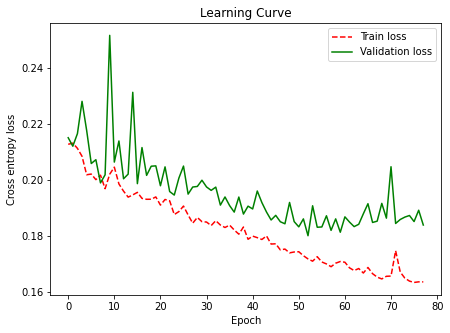


 Test AUC is 0.783432404200236
+----------------------------+------------+
|          Modules           | Parameters |
+----------------------------+------------+
|   GNN1.linear_0_v.weight   |    580     |
|    GNN1.linear_0_v.bias    |     20     |
|   GNN1.linear_0_e.weight   |    380     |
|    GNN1.linear_0_e.bias    |     20     |
|   GNN1.linear_0_g.weight   |    4000    |
|    GNN1.linear_0_g.bias    |     20     |
|   GNN1.linear_e_0.weight   |    2400    |
|    GNN1.linear_e_0.bias    |     20     |
|   GNN1.linear_e_1.weight   |    400     |
|    GNN1.linear_e_1.bias    |     20     |
|   GNN1.linear_m_0.weight   |    800     |
|   GNN1.linear_m_1.weight   |    400     |
|   GNN1.linear_v_0.weight   |    1200    |
|    GNN1.linear_v_0.bias    |     20     |
|   GNN1.linear_v_1.weight   |    400     |
|    GNN1.linear_v_1.bias    |     20     |
|   GNN1.linear_r_0.weight   |    1200    |
|    GNN1.linear_r_0.bias    |     20     |
|   GNN1.linear_r_1.weight   |    400     |


16803

In [ ]:
 
class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(29,19,200,20,20,20,20,20,20,20,20,20,1,20,20,num_layers=1)
        self.linear_1 = nn.Linear(20, 10)
        self.linear_2 = nn.Linear(10, 12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('relu')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses = train_model(model, batch_size=32, optimizer=optimizer, patience=25, n_epochs=10)
model, train_losses, val_losses = train_model(model, batch_size=32, optimizer=optimizer, patience=25, n_epochs=200)
count_parameters(model)

[ 82/200] train_loss: 0.14497 valid_loss: 0.18465
EarlyStopping counter: 25 out of 25
Early Stopping

 Training Time was 697.9332501888275 seconds in cpu




<Figure size 504x360 with 0 Axes>

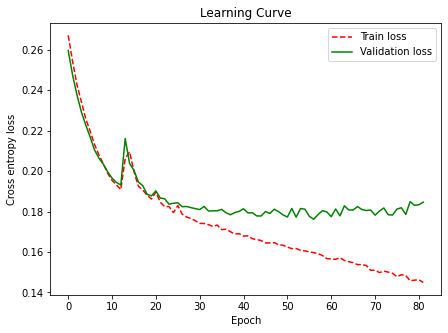


 Test AUC is 0.7858898639678955
+----------------------------+------------+
|          Modules           | Parameters |
+----------------------------+------------+
|   GNN1.linear_0_v.weight   |    725     |
|    GNN1.linear_0_v.bias    |     25     |
|   GNN1.linear_0_e.weight   |    475     |
|    GNN1.linear_0_e.bias    |     25     |
|   GNN1.linear_0_g.weight   |    5000    |
|    GNN1.linear_0_g.bias    |     25     |
|   GNN1.linear_e_0.weight   |    3750    |
|    GNN1.linear_e_0.bias    |     25     |
|   GNN1.linear_e_1.weight   |    625     |
|    GNN1.linear_e_1.bias    |     25     |
|   GNN1.linear_m_0.weight   |    1250    |
|   GNN1.linear_m_1.weight   |    625     |
|   GNN1.linear_v_0.weight   |    1875    |
|    GNN1.linear_v_0.bias    |     25     |
|   GNN1.linear_v_1.weight   |    625     |
|    GNN1.linear_v_1.bias    |     25     |
|   GNN1.linear_r_0.weight   |    1875    |
|    GNN1.linear_r_0.bias    |     25     |
|   GNN1.linear_r_1.weight   |    625     |

24658

In [ ]:

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(29,19,200,25,25,25,25,25,25,25,25,25,1,25,25,num_layers=1)
        self.linear_1 = nn.Linear(25, 15)
        self.linear_2 = nn.Linear(15, 12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = nn.BatchNorm1d(15, affine=False)(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses = train_model(model, batch_size=32, optimizer=optimizer, patience=25, n_epochs=10)
model, train_losses, val_losses = train_model(model, batch_size=32, optimizer=optimizer, patience=25, n_epochs=200)
count_parameters(model)

[160/200] train_loss: 0.12835 valid_loss: 0.22633
EarlyStopping counter: 100 out of 100
Early Stopping

 Training Time was 1261.7272050380707 seconds in cpu




<Figure size 504x360 with 0 Axes>

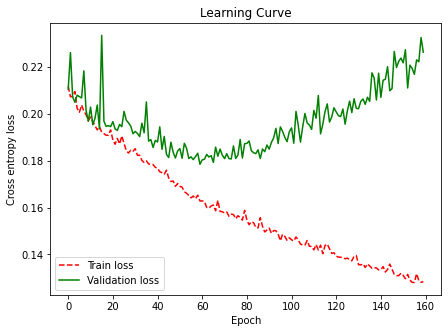


 Test AUC is 0.8039395014444987
+----------------------------+------------+
|          Modules           | Parameters |
+----------------------------+------------+
|   GNN1.linear_0_v.weight   |    580     |
|    GNN1.linear_0_v.bias    |     20     |
|   GNN1.linear_0_e.weight   |    380     |
|    GNN1.linear_0_e.bias    |     20     |
|   GNN1.linear_0_g.weight   |    4000    |
|    GNN1.linear_0_g.bias    |     20     |
|   GNN1.linear_e_0.weight   |    2400    |
|    GNN1.linear_e_0.bias    |     20     |
|   GNN1.linear_e_1.weight   |    400     |
|    GNN1.linear_e_1.bias    |     20     |
|   GNN1.linear_m_0.weight   |    800     |
|   GNN1.linear_m_1.weight   |    400     |
|   GNN1.linear_v_0.weight   |    1200    |
|    GNN1.linear_v_0.bias    |     20     |
|   GNN1.linear_v_1.weight   |    400     |
|    GNN1.linear_v_1.bias    |     20     |
|   GNN1.linear_r_0.weight   |    1200    |
|    GNN1.linear_r_0.bias    |     20     |
|   GNN1.linear_r_1.weight   |    400     |

16803

In [ ]:
 
class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(29,19,200,20,20,20,20,20,20,20,20,20,1,20,20,num_layers=1)
        self.linear_1 = nn.Linear(20, 10)
        self.linear_2 = nn.Linear(10, 12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('relu')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses = train_model(model, batch_size=32, optimizer=optimizer, patience=25, n_epochs=10)
model, train_losses, val_losses = train_model(model, batch_size=32, optimizer=optimizer, patience=100, n_epochs=200)
count_parameters(model)

[143/200] train_loss: 0.11192 valid_loss: 0.20164
EarlyStopping counter: 100 out of 100
Early Stopping

 Training Time was 1166.4221715927124 seconds in cpu




<Figure size 504x360 with 0 Axes>

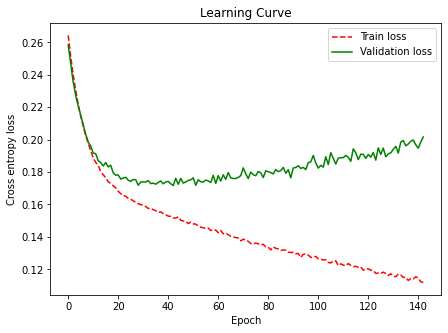


 Test AUC is 0.7991584142049154
+----------------------------+------------+
|          Modules           | Parameters |
+----------------------------+------------+
|   GNN1.linear_0_v.weight   |    580     |
|    GNN1.linear_0_v.bias    |     20     |
|   GNN1.linear_0_e.weight   |    380     |
|    GNN1.linear_0_e.bias    |     20     |
|   GNN1.linear_0_g.weight   |    4000    |
|    GNN1.linear_0_g.bias    |     20     |
|   GNN1.linear_e_0.weight   |    2400    |
|    GNN1.linear_e_0.bias    |     20     |
|   GNN1.linear_e_1.weight   |    400     |
|    GNN1.linear_e_1.bias    |     20     |
|   GNN1.linear_m_0.weight   |    800     |
|   GNN1.linear_m_1.weight   |    400     |
|   GNN1.linear_v_0.weight   |    1200    |
|    GNN1.linear_v_0.bias    |     20     |
|   GNN1.linear_v_1.weight   |    400     |
|    GNN1.linear_v_1.bias    |     20     |
|   GNN1.linear_r_0.weight   |    1200    |
|    GNN1.linear_r_0.bias    |     20     |
|   GNN1.linear_r_1.weight   |    400     |

16803

In [ ]:

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(29,19,200,20,20,20,20,20,20,20,20,20,1,20,20,num_layers=1)
        self.linear_1 = nn.Linear(20, 10)
        self.linear_2 = nn.Linear(10, 12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = nn.BatchNorm1d(10, affine=False)(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses = train_model(model, batch_size=32, optimizer=optimizer, patience=25, n_epochs=10)
model, train_losses, val_losses = train_model(model, batch_size=32, optimizer=optimizer, patience=100, n_epochs=200)
count_parameters(model)

[200/200] train_loss: 0.22292 valid_loss: 0.22029
EarlyStopping counter: 94 out of 100

 Training Time was 1412.3646638393402 seconds in cpu




<Figure size 504x360 with 0 Axes>

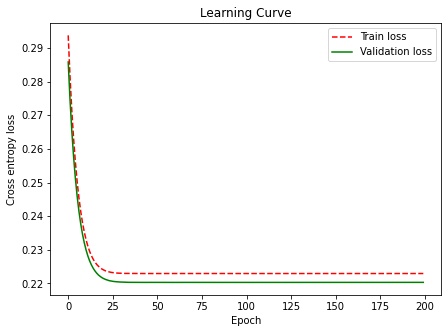


 Test AUC is 0.499456524848938
+----------------------------+------------+
|          Modules           | Parameters |
+----------------------------+------------+
|   GNN1.linear_0_v.weight   |    522     |
|    GNN1.linear_0_v.bias    |     18     |
|   GNN1.linear_0_e.weight   |    342     |
|    GNN1.linear_0_e.bias    |     18     |
|   GNN1.linear_0_g.weight   |    3600    |
|    GNN1.linear_0_g.bias    |     18     |
|   GNN1.linear_e_0.weight   |    1944    |
|    GNN1.linear_e_0.bias    |     18     |
|   GNN1.linear_e_1.weight   |    324     |
|    GNN1.linear_e_1.bias    |     18     |
|   GNN1.linear_m_0.weight   |    648     |
|   GNN1.linear_m_1.weight   |    324     |
|   GNN1.linear_v_0.weight   |    972     |
|    GNN1.linear_v_0.bias    |     18     |
|   GNN1.linear_v_1.weight   |    324     |
|    GNN1.linear_v_1.bias    |     18     |
|   GNN1.linear_r_0.weight   |    972     |
|    GNN1.linear_r_0.bias    |     18     |
|   GNN1.linear_r_1.weight   |    324     |


14129

In [ ]:

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(29,19,200,18,18,18,18,18,18,18,18,18,1,18,18,num_layers=1)
        self.linear_1 = nn.Linear(18, 10)
        self.linear_2 = nn.Linear(10, 12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('relu')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses = train_model(model, batch_size=32, optimizer=optimizer, patience=25, n_epochs=10)
model, train_losses, val_losses = train_model(model, batch_size=32, optimizer=optimizer, patience=100, n_epochs=200)
count_parameters(model)

[101/200] train_loss: 0.14051 valid_loss: 0.19203
EarlyStopping counter: 50 out of 50
Early Stopping

 Training Time was 778.6889843940735 seconds in cpu




<Figure size 504x360 with 0 Axes>

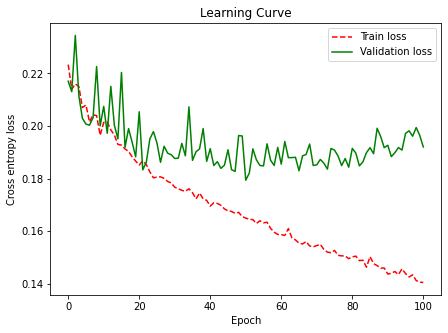


 Test AUC is 0.7757885456085205
+----------------------------+------------+
|          Modules           | Parameters |
+----------------------------+------------+
|   GNN1.linear_0_v.weight   |    580     |
|    GNN1.linear_0_v.bias    |     20     |
|   GNN1.linear_0_e.weight   |    380     |
|    GNN1.linear_0_e.bias    |     20     |
|   GNN1.linear_0_g.weight   |    4000    |
|    GNN1.linear_0_g.bias    |     20     |
|   GNN1.linear_e_0.weight   |    2400    |
|    GNN1.linear_e_0.bias    |     20     |
|   GNN1.linear_e_1.weight   |    400     |
|    GNN1.linear_e_1.bias    |     20     |
|   GNN1.linear_m_0.weight   |    800     |
|   GNN1.linear_m_1.weight   |    400     |
|   GNN1.linear_v_0.weight   |    1200    |
|    GNN1.linear_v_0.bias    |     20     |
|   GNN1.linear_v_1.weight   |    400     |
|    GNN1.linear_v_1.bias    |     20     |
|   GNN1.linear_r_0.weight   |    1200    |
|    GNN1.linear_r_0.bias    |     20     |
|   GNN1.linear_r_1.weight   |    400     |

16968

In [ ]:
 
class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(29,19,200,20,20,20,20,20,20,20,20,20,1,20,20,num_layers=1)
        self.linear_1 = nn.Linear(20, 15)
        self.linear_2 = nn.Linear(15, 12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('relu')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)   
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses = train_model(model, batch_size=32, optimizer=optimizer, patience=25, n_epochs=10)
model, train_losses, val_losses = train_model(model, batch_size=32, optimizer=optimizer, patience=50, n_epochs=200)
count_parameters(model)

[ 75/200] train_loss: 0.15285 valid_loss: 0.19424
EarlyStopping counter: 25 out of 25
Early Stopping

 Training Time was 585.5982549190521 seconds in cpu




<Figure size 504x360 with 0 Axes>

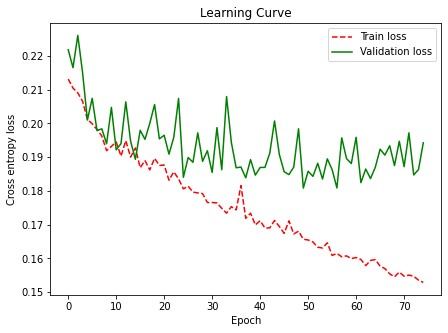


 Test AUC is 0.8015087445576986
+----------------------------+------------+
|          Modules           | Parameters |
+----------------------------+------------+
|   GNN1.linear_0_v.weight   |    580     |
|    GNN1.linear_0_v.bias    |     20     |
|   GNN1.linear_0_e.weight   |    380     |
|    GNN1.linear_0_e.bias    |     20     |
|   GNN1.linear_0_g.weight   |    4000    |
|    GNN1.linear_0_g.bias    |     20     |
|   GNN1.linear_e_0.weight   |    2400    |
|    GNN1.linear_e_0.bias    |     20     |
|   GNN1.linear_e_1.weight   |    400     |
|    GNN1.linear_e_1.bias    |     20     |
|   GNN1.linear_m_0.weight   |    800     |
|   GNN1.linear_m_1.weight   |    400     |
|   GNN1.linear_v_0.weight   |    1200    |
|    GNN1.linear_v_0.bias    |     20     |
|   GNN1.linear_v_1.weight   |    400     |
|    GNN1.linear_v_1.bias    |     20     |
|   GNN1.linear_r_0.weight   |    1200    |
|    GNN1.linear_r_0.bias    |     20     |
|   GNN1.linear_r_1.weight   |    400     |

16803

In [ ]:
 
class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(29,19,200,20,20,20,20,20,20,20,20,20,1,20,20,num_layers=1)
        self.linear_1 = nn.Linear(20, 10)
        self.linear_2 = nn.Linear(10, 12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('relu')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses = train_model(model, batch_size=32, optimizer=optimizer, patience=25, n_epochs=10)
model, train_losses, val_losses = train_model(model, batch_size=32, optimizer=optimizer, patience=25, n_epochs=200)
count_parameters(model)

[ 28/200] train_loss: 20.21241 valid_loss: 20.23047
EarlyStopping counter: 25 out of 25
Early Stopping

 Training Time was 224.7970209121704 seconds in cpu




<Figure size 504x360 with 0 Axes>

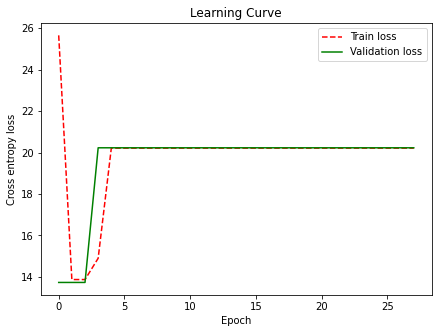


 Test AUC is 0.4931577841440837
+----------------------------+------------+
|          Modules           | Parameters |
+----------------------------+------------+
|   GNN1.linear_0_v.weight   |    870     |
|    GNN1.linear_0_v.bias    |     30     |
|   GNN1.linear_0_e.weight   |    570     |
|    GNN1.linear_0_e.bias    |     30     |
|   GNN1.linear_0_g.weight   |    6000    |
|    GNN1.linear_0_g.bias    |     30     |
|   GNN1.linear_e_0.weight   |    5400    |
|    GNN1.linear_e_0.bias    |     30     |
|   GNN1.linear_e_1.weight   |    900     |
|    GNN1.linear_e_1.bias    |     30     |
|   GNN1.linear_m_0.weight   |    1800    |
|   GNN1.linear_m_1.weight   |    900     |
|   GNN1.linear_v_0.weight   |    2700    |
|    GNN1.linear_v_0.bias    |     30     |
|   GNN1.linear_v_1.weight   |    900     |
|    GNN1.linear_v_1.bias    |     30     |
|   GNN1.linear_r_0.weight   |    2700    |
|    GNN1.linear_r_0.bias    |     30     |
|   GNN1.linear_r_1.weight   |    900     |

33963

In [ ]:
 
class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(29,19,200,30,30,30,30,30,30,30,30,30,1,30,30,num_layers=1)
        self.linear_1 = nn.Linear(30, 20)
        self.linear_2 = nn.Linear(20, 12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('relu')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
count_parameters(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses = train_model(model, batch_size=32, optimizer=optimizer, patience=25, n_epochs=200)
count_parameters(model)

[120/200] train_loss: 0.14803 valid_loss: 0.18458
EarlyStopping counter: 25 out of 25
Early Stopping

 Training Time was 874.0689017772675 seconds in cpu




<Figure size 504x360 with 0 Axes>

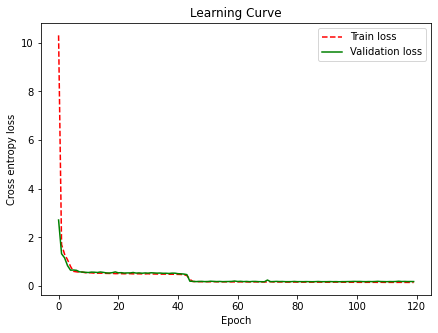


 Test AUC is 0.7877240180969238
+----------------------------+------------+
|          Modules           | Parameters |
+----------------------------+------------+
|   GNN1.linear_0_v.weight   |    435     |
|    GNN1.linear_0_v.bias    |     15     |
|   GNN1.linear_0_e.weight   |    285     |
|    GNN1.linear_0_e.bias    |     15     |
|   GNN1.linear_0_g.weight   |    3000    |
|    GNN1.linear_0_g.bias    |     15     |
|   GNN1.linear_e_0.weight   |    1350    |
|    GNN1.linear_e_0.bias    |     15     |
|   GNN1.linear_e_1.weight   |    225     |
|    GNN1.linear_e_1.bias    |     15     |
|   GNN1.linear_m_0.weight   |    450     |
|   GNN1.linear_m_1.weight   |    225     |
|   GNN1.linear_v_0.weight   |    675     |
|    GNN1.linear_v_0.bias    |     15     |
|   GNN1.linear_v_1.weight   |    225     |
|    GNN1.linear_v_1.bias    |     15     |
|   GNN1.linear_r_0.weight   |    675     |
|    GNN1.linear_r_0.bias    |     15     |
|   GNN1.linear_r_1.weight   |    225     |

10678

In [ ]:
 
class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(29,19,200,15,15,15,15,15,15,15,15,15,1,15,15,num_layers=1)
        self.linear_1 = nn.Linear(15, 15)
        self.linear_2 = nn.Linear(15, 12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('relu')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
count_parameters(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses = train_model(model, batch_size=32, optimizer=optimizer, patience=25, n_epochs=200)
count_parameters(model)

[ 86/200] train_loss: 0.16424 valid_loss: 0.19471
EarlyStopping counter: 25 out of 25
Early Stopping

 Training Time was 581.8787331581116 seconds in cpu




<Figure size 504x360 with 0 Axes>

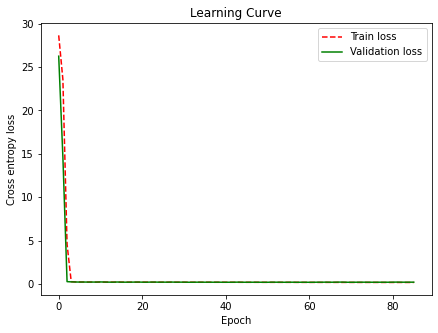


 Test AUC is 0.771021842956543
+----------------------------+------------+
|          Modules           | Parameters |
+----------------------------+------------+
|   GNN1.linear_0_v.weight   |    435     |
|    GNN1.linear_0_v.bias    |     15     |
|   GNN1.linear_0_e.weight   |    285     |
|    GNN1.linear_0_e.bias    |     15     |
|   GNN1.linear_0_g.weight   |    3000    |
|    GNN1.linear_0_g.bias    |     15     |
|   GNN1.linear_e_0.weight   |    1350    |
|    GNN1.linear_e_0.bias    |     15     |
|   GNN1.linear_e_1.weight   |    225     |
|    GNN1.linear_e_1.bias    |     15     |
|   GNN1.linear_m_0.weight   |    450     |
|   GNN1.linear_m_1.weight   |    225     |
|   GNN1.linear_v_0.weight   |    675     |
|    GNN1.linear_v_0.bias    |     15     |
|   GNN1.linear_v_1.weight   |    225     |
|    GNN1.linear_v_1.bias    |     15     |
|   GNN1.linear_r_0.weight   |    675     |
|    GNN1.linear_r_0.bias    |     15     |
|   GNN1.linear_r_1.weight   |    225     |


10678

In [ ]:
 
class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(29,19,200,15,15,15,15,15,15,15,15,15,1,15,15,num_layers=1)
        self.linear_1 = nn.Linear(15, 15)
        self.linear_2 = nn.Linear(15, 12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('relu')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
count_parameters(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses = train_model(model, batch_size=32, optimizer=optimizer, patience=25, n_epochs=200)
count_parameters(model)

[ 86/200] train_loss: 0.16052 valid_loss: 0.19061
EarlyStopping counter: 25 out of 25
Early Stopping

 Training Time was 689.5369205474854 seconds in cpu




<Figure size 504x360 with 0 Axes>

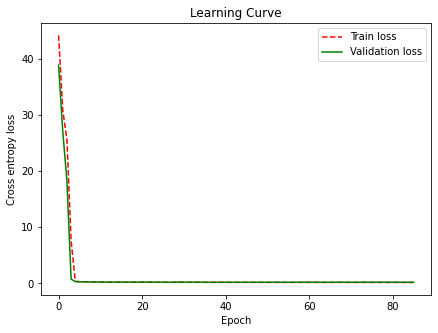


 Test AUC is 0.772287925084432
+----------------------------+------------+
|          Modules           | Parameters |
+----------------------------+------------+
|   GNN1.linear_0_v.weight   |    435     |
|    GNN1.linear_0_v.bias    |     15     |
|   GNN1.linear_0_e.weight   |    285     |
|    GNN1.linear_0_e.bias    |     15     |
|   GNN1.linear_0_g.weight   |    3000    |
|    GNN1.linear_0_g.bias    |     15     |
|   GNN1.linear_e_0.weight   |    1350    |
|    GNN1.linear_e_0.bias    |     15     |
|   GNN1.linear_e_1.weight   |    225     |
|    GNN1.linear_e_1.bias    |     15     |
|   GNN1.linear_m_0.weight   |    450     |
|   GNN1.linear_m_1.weight   |    225     |
|   GNN1.linear_v_0.weight   |    675     |
|    GNN1.linear_v_0.bias    |     15     |
|   GNN1.linear_v_1.weight   |    225     |
|    GNN1.linear_v_1.bias    |     15     |
|   GNN1.linear_r_0.weight   |    675     |
|    GNN1.linear_r_0.bias    |     15     |
|   GNN1.linear_r_1.weight   |    225     |


10438

In [ ]:
 
class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(29,19,200,15,15,15,15,15,15,15,15,15,1,15,15,num_layers=1)
        self.linear = nn.Linear(15, 12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('linear')
        nn.init.xavier_normal_(self.linear.weight, gain=gain) 
    def forward(self, mol_dgl_graph,fg):
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.sigmoid(self.linear(output))   
      return output
model= GNN().to(device)
count_parameters(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses = train_model(model, batch_size=32, optimizer=optimizer, patience=25, n_epochs=200)
count_parameters(model)

[ 95/200] train_loss: 0.16063 valid_loss: 0.18688
EarlyStopping counter: 25 out of 25
Early Stopping

 Training Time was 767.2161655426025 seconds in cpu




<Figure size 504x360 with 0 Axes>

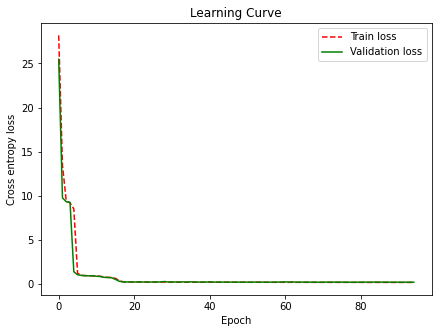


 Test AUC is 0.7894836266835531
+----------------------------+------------+
|          Modules           | Parameters |
+----------------------------+------------+
|   GNN1.linear_0_v.weight   |    435     |
|    GNN1.linear_0_v.bias    |     15     |
|   GNN1.linear_0_e.weight   |    285     |
|    GNN1.linear_0_e.bias    |     15     |
|   GNN1.linear_0_g.weight   |    3000    |
|    GNN1.linear_0_g.bias    |     15     |
|   GNN1.linear_e_0.weight   |    1350    |
|    GNN1.linear_e_0.bias    |     15     |
|   GNN1.linear_e_1.weight   |    225     |
|    GNN1.linear_e_1.bias    |     15     |
|   GNN1.linear_m_0.weight   |    450     |
|   GNN1.linear_m_1.weight   |    225     |
|   GNN1.linear_v_0.weight   |    675     |
|    GNN1.linear_v_0.bias    |     15     |
|   GNN1.linear_v_1.weight   |    225     |
|    GNN1.linear_v_1.bias    |     15     |
|   GNN1.linear_r_0.weight   |    675     |
|    GNN1.linear_r_0.bias    |     15     |
|   GNN1.linear_r_1.weight   |    225     |

10438

In [ ]:
 
class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(29,19,200,15,15,15,15,15,15,15,15,15,1,15,15,num_layers=1)
        self.linear = nn.Linear(15, 12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('linear')
        nn.init.xavier_normal_(self.linear.weight, gain=gain) 
    def forward(self, mol_dgl_graph,fg):
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.sigmoid(self.linear(output))   
      return output
model= GNN().to(device)
count_parameters(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses = train_model(model, batch_size=32, optimizer=optimizer, patience=25, n_epochs=200)
count_parameters(model)

In [ ]:
 
class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(29,19,200,30,30,30,30,30,30,30,30,30,1,30,30,num_layers=2)
        self.linear = nn.Linear(30, 12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('linear')
        nn.init.xavier_normal_(self.linear.weight, gain=gain) 
    def forward(self, mol_dgl_graph,fg):
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.sigmoid(self.linear(output))   
      return output
model= GNN().to(device)
count_parameters(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses = train_model(model, batch_size=32, optimizer=optimizer, patience=25, n_epochs=200)
count_parameters(model)

[  9/200] train_loss: 43.14424 valid_loss: 43.16048
Validation loss decreased (43.160479 --> 43.160479).  Saving model ...


KeyboardInterrupt: ignored

[ 36/200] train_loss: 13.87911 valid_loss: 13.86043
EarlyStopping counter: 25 out of 25
Early Stopping

 Training Time was 387.72319984436035 seconds in cpu




<Figure size 504x360 with 0 Axes>

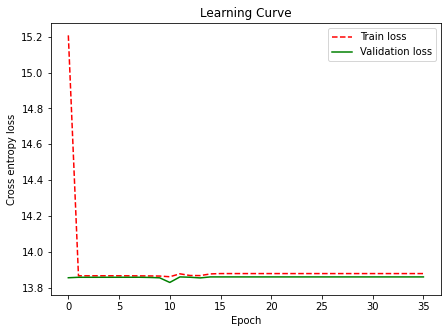


 Test AUC is 0.49848989645640057
+----------------------------+------------+
|          Modules           | Parameters |
+----------------------------+------------+
|   GNN1.linear_0_v.weight   |    1015    |
|    GNN1.linear_0_v.bias    |     35     |
|   GNN1.linear_0_e.weight   |    665     |
|    GNN1.linear_0_e.bias    |     35     |
|   GNN1.linear_0_g.weight   |    7000    |
|    GNN1.linear_0_g.bias    |     35     |
|   GNN1.linear_e_0.weight   |    7350    |
|    GNN1.linear_e_0.bias    |     35     |
|   GNN1.linear_e_1.weight   |    1225    |
|    GNN1.linear_e_1.bias    |     35     |
|   GNN1.linear_m_0.weight   |    2450    |
|   GNN1.linear_m_1.weight   |    1225    |
|   GNN1.linear_v_0.weight   |    3675    |
|    GNN1.linear_v_0.bias    |     35     |
|   GNN1.linear_v_1.weight   |    1225    |
|    GNN1.linear_v_1.bias    |     35     |
|   GNN1.linear_r_0.weight   |    3675    |
|    GNN1.linear_r_0.bias    |     35     |
|   GNN1.linear_r_1.weight   |    1225    

43938

In [ ]:
 
class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(29,19,200,35,35,35,35,35,35,35,35,35,1,35,35,num_layers=1)
        self.linear = nn.Linear(35, 12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('linear')
        nn.init.xavier_normal_(self.linear.weight, gain=gain) 
    def forward(self, mol_dgl_graph,fg):
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.sigmoid(self.linear(output))   
      return output
model= GNN().to(device)
count_parameters(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses = train_model(model, batch_size=32, optimizer=optimizer, patience=25, n_epochs=200)
count_parameters(model)

[ 26/200] train_loss: 13.87920 valid_loss: 13.86043
EarlyStopping counter: 25 out of 25
Early Stopping

 Training Time was 287.7625403404236 seconds in cpu




<Figure size 504x360 with 0 Axes>

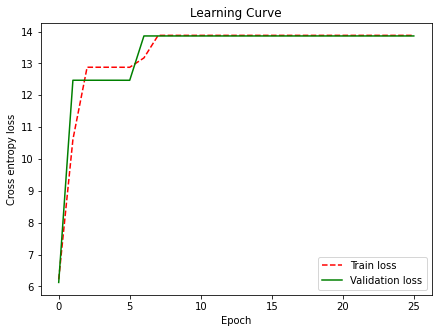


 Test AUC is 0.5017700990041097
+----------------------------+------------+
|          Modules           | Parameters |
+----------------------------+------------+
|   GNN1.linear_0_v.weight   |    1160    |
|    GNN1.linear_0_v.bias    |     40     |
|   GNN1.linear_0_e.weight   |    760     |
|    GNN1.linear_0_e.bias    |     40     |
|   GNN1.linear_0_g.weight   |    8000    |
|    GNN1.linear_0_g.bias    |     40     |
|   GNN1.linear_e_0.weight   |    9600    |
|    GNN1.linear_e_0.bias    |     40     |
|   GNN1.linear_e_1.weight   |    1600    |
|    GNN1.linear_e_1.bias    |     40     |
|   GNN1.linear_m_0.weight   |    3200    |
|   GNN1.linear_m_1.weight   |    1600    |
|   GNN1.linear_v_0.weight   |    4800    |
|    GNN1.linear_v_0.bias    |     40     |
|   GNN1.linear_v_1.weight   |    1600    |
|    GNN1.linear_v_1.bias    |     40     |
|   GNN1.linear_r_0.weight   |    4800    |
|    GNN1.linear_r_0.bias    |     40     |
|   GNN1.linear_r_1.weight   |    1600    |

55813

In [ ]:
 
class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(29,19,200,40,40,40,40,40,40,40,40,40,1,40,40,num_layers=1)
        self.linear = nn.Linear(40, 12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('linear')
        nn.init.xavier_normal_(self.linear.weight, gain=gain) 
    def forward(self, mol_dgl_graph,fg):
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.sigmoid(self.linear(output))   
      return output
model= GNN().to(device)
count_parameters(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses = train_model(model, batch_size=32, optimizer=optimizer, patience=25, n_epochs=200)
count_parameters(model)

[ 78/200] train_loss: 0.14591 valid_loss: 0.20456
EarlyStopping counter: 25 out of 25
Early Stopping

 Training Time was 775.3250684738159 seconds in cpu




<Figure size 504x360 with 0 Axes>

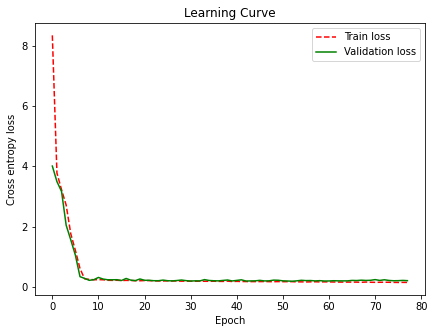


 Test AUC is 0.7824610869089762
+----------------------------+------------+
|          Modules           | Parameters |
+----------------------------+------------+
|   GNN1.linear_0_v.weight   |    870     |
|    GNN1.linear_0_v.bias    |     30     |
|   GNN1.linear_0_e.weight   |    570     |
|    GNN1.linear_0_e.bias    |     30     |
|   GNN1.linear_0_g.weight   |    6000    |
|    GNN1.linear_0_g.bias    |     30     |
|   GNN1.linear_e_0.weight   |    5400    |
|    GNN1.linear_e_0.bias    |     30     |
|   GNN1.linear_e_1.weight   |    900     |
|    GNN1.linear_e_1.bias    |     30     |
|   GNN1.linear_m_0.weight   |    1800    |
|   GNN1.linear_m_1.weight   |    900     |
|   GNN1.linear_v_0.weight   |    2700    |
|    GNN1.linear_v_0.bias    |     30     |
|   GNN1.linear_v_1.weight   |    900     |
|    GNN1.linear_v_1.bias    |     30     |
|   GNN1.linear_r_0.weight   |    2700    |
|    GNN1.linear_r_0.bias    |     30     |
|   GNN1.linear_r_1.weight   |    900     |

33463

In [ ]:
 
class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(29,19,200,30,30,30,30,30,30,30,30,30,1,30,30,num_layers=1)
        self.linear = nn.Linear(30, 12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('linear')
        nn.init.xavier_normal_(self.linear.weight, gain=gain) 
    def forward(self, mol_dgl_graph,fg):
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.sigmoid(self.linear(output))   
      return output
model= GNN().to(device)
count_parameters(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses = train_model(model, batch_size=32, optimizer=optimizer, patience=25, n_epochs=200)
count_parameters(model)

[ 90/200] train_loss: 0.15614 valid_loss: 0.19595
EarlyStopping counter: 25 out of 25
Early Stopping

 Training Time was 748.0274591445923 seconds in cpu




<Figure size 504x360 with 0 Axes>

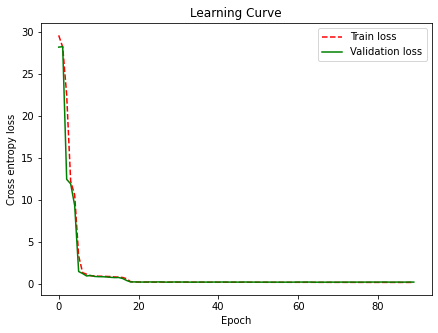


 Test AUC is 0.7864276568094889
+----------------------------+------------+
|          Modules           | Parameters |
+----------------------------+------------+
|   GNN1.linear_0_v.weight   |    580     |
|    GNN1.linear_0_v.bias    |     20     |
|   GNN1.linear_0_e.weight   |    380     |
|    GNN1.linear_0_e.bias    |     20     |
|   GNN1.linear_0_g.weight   |    4000    |
|    GNN1.linear_0_g.bias    |     20     |
|   GNN1.linear_e_0.weight   |    2400    |
|    GNN1.linear_e_0.bias    |     20     |
|   GNN1.linear_e_1.weight   |    400     |
|    GNN1.linear_e_1.bias    |     20     |
|   GNN1.linear_m_0.weight   |    800     |
|   GNN1.linear_m_1.weight   |    400     |
|   GNN1.linear_v_0.weight   |    1200    |
|    GNN1.linear_v_0.bias    |     20     |
|   GNN1.linear_v_1.weight   |    400     |
|    GNN1.linear_v_1.bias    |     20     |
|   GNN1.linear_r_0.weight   |    1200    |
|    GNN1.linear_r_0.bias    |     20     |
|   GNN1.linear_r_1.weight   |    400     |

16713

In [ ]:
 
class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(29,19,200,20,20,20,20,20,20,20,20,20,1,20,20,num_layers=1)
        self.linear = nn.Linear(20, 12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('linear')
        nn.init.xavier_normal_(self.linear.weight, gain=gain) 
    def forward(self, mol_dgl_graph,fg):
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.sigmoid(self.linear(output))   
      return output
model= GNN().to(device)
count_parameters(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses = train_model(model, batch_size=32, optimizer=optimizer, patience=25, n_epochs=200)
count_parameters(model)

[ 95/200] train_loss: 0.16063 valid_loss: 0.18688
EarlyStopping counter: 25 out of 25
Early Stopping

 Training Time was 767.2161655426025 seconds in cpu




<Figure size 504x360 with 0 Axes>

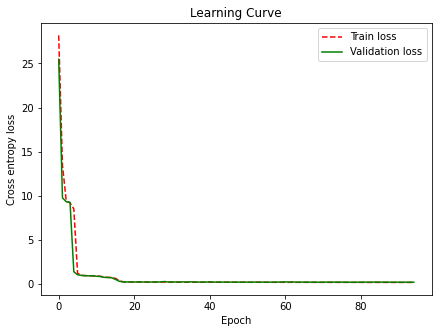


 Test AUC is 0.7894836266835531
+----------------------------+------------+
|          Modules           | Parameters |
+----------------------------+------------+
|   GNN1.linear_0_v.weight   |    435     |
|    GNN1.linear_0_v.bias    |     15     |
|   GNN1.linear_0_e.weight   |    285     |
|    GNN1.linear_0_e.bias    |     15     |
|   GNN1.linear_0_g.weight   |    3000    |
|    GNN1.linear_0_g.bias    |     15     |
|   GNN1.linear_e_0.weight   |    1350    |
|    GNN1.linear_e_0.bias    |     15     |
|   GNN1.linear_e_1.weight   |    225     |
|    GNN1.linear_e_1.bias    |     15     |
|   GNN1.linear_m_0.weight   |    450     |
|   GNN1.linear_m_1.weight   |    225     |
|   GNN1.linear_v_0.weight   |    675     |
|    GNN1.linear_v_0.bias    |     15     |
|   GNN1.linear_v_1.weight   |    225     |
|    GNN1.linear_v_1.bias    |     15     |
|   GNN1.linear_r_0.weight   |    675     |
|    GNN1.linear_r_0.bias    |     15     |
|   GNN1.linear_r_1.weight   |    225     |

10438

In [ ]:
 
class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(29,19,200,15,15,15,15,15,15,15,15,15,1,15,15,num_layers=1)
        self.linear = nn.Linear(15, 12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('linear')
        nn.init.xavier_normal_(self.linear.weight, gain=gain) 
    def forward(self, mol_dgl_graph,fg):
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.sigmoid(self.linear(output))   
      return output
model= GNN().to(device)
count_parameters(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses = train_model(model, batch_size=32, optimizer=optimizer, patience=25, n_epochs=200)
count_parameters(model)

[200/200] train_loss: 0.18493 valid_loss: 0.19931
EarlyStopping counter: 20 out of 25

 Training Time was 1610.0665135383606 seconds in cpu




<Figure size 504x360 with 0 Axes>

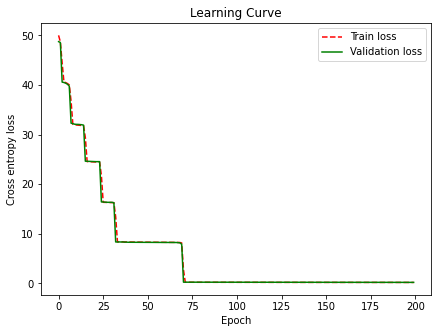


 Test AUC is 0.7577548821767172
+----------------------------+------------+
|          Modules           | Parameters |
+----------------------------+------------+
|   GNN1.linear_0_v.weight   |    435     |
|    GNN1.linear_0_v.bias    |     15     |
|   GNN1.linear_0_e.weight   |    285     |
|    GNN1.linear_0_e.bias    |     15     |
|   GNN1.linear_0_g.weight   |    3000    |
|    GNN1.linear_0_g.bias    |     15     |
|   GNN1.linear_e_0.weight   |    1350    |
|    GNN1.linear_e_0.bias    |     15     |
|   GNN1.linear_e_1.weight   |    225     |
|    GNN1.linear_e_1.bias    |     15     |
|   GNN1.linear_m_0.weight   |    450     |
|   GNN1.linear_m_1.weight   |    225     |
|   GNN1.linear_v_0.weight   |    675     |
|    GNN1.linear_v_0.bias    |     15     |
|   GNN1.linear_v_1.weight   |    225     |
|    GNN1.linear_v_1.bias    |     15     |
|   GNN1.linear_r_0.weight   |    675     |
|    GNN1.linear_r_0.bias    |     15     |
|   GNN1.linear_r_1.weight   |    225     |

10438

In [ ]:
 
class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(29,19,200,15,15,15,15,15,15,15,15,15,1,15,15,num_layers=1)
        self.linear = nn.Linear(15, 12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('linear')
        nn.init.xavier_normal_(self.linear.weight, gain=gain) 
    def forward(self, mol_dgl_graph,fg):
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.sigmoid(self.linear(output))   
      return output
model= GNN().to(device)
count_parameters(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
model, train_losses, val_losses = train_model(model, batch_size=32, optimizer=optimizer, patience=25, n_epochs=200)
count_parameters(model)

[130/200] train_loss: 0.16424 valid_loss: 0.18916
EarlyStopping counter: 25 out of 25
Early Stopping

 Training Time was 971.2683477401733 seconds in cpu




<Figure size 504x360 with 0 Axes>

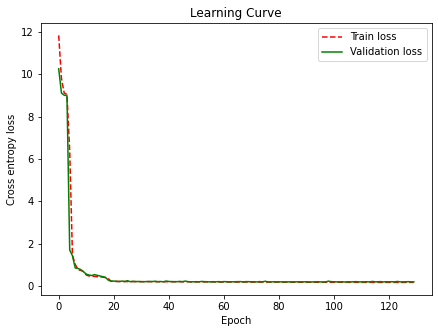


 Test AUC is 0.7811048030853271
+----------------------------+------------+
|          Modules           | Parameters |
+----------------------------+------------+
|   GNN1.linear_0_v.weight   |    290     |
|    GNN1.linear_0_v.bias    |     10     |
|   GNN1.linear_0_e.weight   |    190     |
|    GNN1.linear_0_e.bias    |     10     |
|   GNN1.linear_0_g.weight   |    2000    |
|    GNN1.linear_0_g.bias    |     10     |
|   GNN1.linear_e_0.weight   |    600     |
|    GNN1.linear_e_0.bias    |     10     |
|   GNN1.linear_e_1.weight   |    100     |
|    GNN1.linear_e_1.bias    |     10     |
|   GNN1.linear_m_0.weight   |    200     |
|   GNN1.linear_m_1.weight   |    100     |
|   GNN1.linear_v_0.weight   |    300     |
|    GNN1.linear_v_0.bias    |     10     |
|   GNN1.linear_v_1.weight   |    100     |
|    GNN1.linear_v_1.bias    |     10     |
|   GNN1.linear_r_0.weight   |    300     |
|    GNN1.linear_r_0.bias    |     10     |
|   GNN1.linear_r_1.weight   |    100     |

5563

In [ ]:
 
class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(29,19,200,10,10,10,10,10,10,10,10,10,1,10,10,num_layers=1)
        self.linear = nn.Linear(10, 12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('linear')
        nn.init.xavier_normal_(self.linear.weight, gain=gain) 
    def forward(self, mol_dgl_graph,fg):
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.sigmoid(self.linear(output))   
      return output
model= GNN().to(device)
count_parameters(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses = train_model(model, batch_size=32, optimizer=optimizer, patience=25, n_epochs=200)
count_parameters(model)

[ 68/200] train_loss: 0.17846 valid_loss: 0.20162
EarlyStopping counter: 25 out of 25
Early Stopping

 Training Time was 509.9691789150238 seconds in cpu




<Figure size 504x360 with 0 Axes>

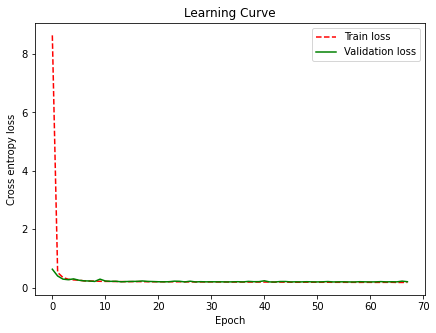


 Test AUC is 0.7572577794392904
+----------------------------+------------+
|          Modules           | Parameters |
+----------------------------+------------+
|   GNN1.linear_0_v.weight   |    290     |
|    GNN1.linear_0_v.bias    |     10     |
|   GNN1.linear_0_e.weight   |    190     |
|    GNN1.linear_0_e.bias    |     10     |
|   GNN1.linear_0_g.weight   |    2000    |
|    GNN1.linear_0_g.bias    |     10     |
|   GNN1.linear_e_0.weight   |    600     |
|    GNN1.linear_e_0.bias    |     10     |
|   GNN1.linear_e_1.weight   |    100     |
|    GNN1.linear_e_1.bias    |     10     |
|   GNN1.linear_m_0.weight   |    200     |
|   GNN1.linear_m_1.weight   |    100     |
|   GNN1.linear_v_0.weight   |    300     |
|    GNN1.linear_v_0.bias    |     10     |
|   GNN1.linear_v_1.weight   |    100     |
|    GNN1.linear_v_1.bias    |     10     |
|   GNN1.linear_r_0.weight   |    300     |
|    GNN1.linear_r_0.bias    |     10     |
|   GNN1.linear_r_1.weight   |    100     |

5563

In [ ]:
 
class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(29,19,200,10,10,10,10,10,10,10,10,10,1,10,10,num_layers=1)
        self.linear = nn.Linear(10, 12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('linear')
        nn.init.xavier_normal_(self.linear.weight, gain=gain) 
    def forward(self, mol_dgl_graph,fg):
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.sigmoid(self.linear(output))   
      return output
model= GNN().to(device)
count_parameters(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses = train_model(model, batch_size=32, optimizer=optimizer, patience=25, n_epochs=200)
count_parameters(model)

[136/200] train_loss: 0.16047 valid_loss: 0.18686
EarlyStopping counter: 25 out of 25
Early Stopping

 Training Time was 1009.0602416992188 seconds in cpu




<Figure size 504x360 with 0 Axes>

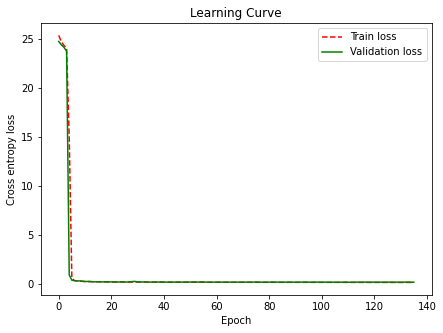


 Test AUC is 0.7798229058583578
+----------------------------+------------+
|          Modules           | Parameters |
+----------------------------+------------+
|   GNN1.linear_0_v.weight   |    290     |
|    GNN1.linear_0_v.bias    |     10     |
|   GNN1.linear_0_e.weight   |    190     |
|    GNN1.linear_0_e.bias    |     10     |
|   GNN1.linear_0_g.weight   |    2000    |
|    GNN1.linear_0_g.bias    |     10     |
|   GNN1.linear_e_0.weight   |    500     |
|    GNN1.linear_e_0.bias    |     10     |
|   GNN1.linear_e_1.weight   |    100     |
|    GNN1.linear_e_1.bias    |     10     |
|   GNN1.linear_m_0.weight   |    200     |
|   GNN1.linear_m_1.weight   |    100     |
|   GNN1.linear_v_0.weight   |    300     |
|    GNN1.linear_v_0.bias    |     10     |
|   GNN1.linear_v_1.weight   |    100     |
|    GNN1.linear_v_1.bias    |     10     |
|   GNN1.linear_r_0.weight   |    300     |
|    GNN1.linear_r_0.bias    |     10     |
|   GNN1.linear_r_1.weight   |    100     |

5363

In [ ]:
# In this setting Edge updater dose not have it own state!
class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(29,19,200,10,10,10,10,10,10,10,10,10,1,10,10,num_layers=1)
        self.linear = nn.Linear(10, 12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('linear')
        nn.init.xavier_normal_(self.linear.weight, gain=gain) 
    def forward(self, mol_dgl_graph,fg):
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.sigmoid(self.linear(output))   
      return output
model= GNN().to(device)
count_parameters(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses = train_model(model, batch_size=32, optimizer=optimizer, patience=25, n_epochs=200)
count_parameters(model)

[153/200] train_loss: 0.16300 valid_loss: 0.18885
EarlyStopping counter: 25 out of 25
Early Stopping

 Training Time was 977.116571187973 seconds in cpu




<Figure size 504x360 with 0 Axes>

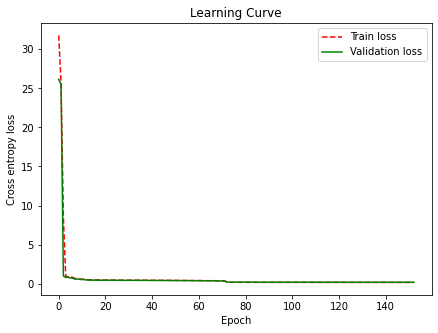


 Test AUC is 0.7661382357279459
+----------------------------+------------+
|          Modules           | Parameters |
+----------------------------+------------+
|   GNN1.linear_0_v.weight   |    290     |
|    GNN1.linear_0_v.bias    |     10     |
|   GNN1.linear_0_e.weight   |    190     |
|    GNN1.linear_0_e.bias    |     10     |
|   GNN1.linear_0_g.weight   |    2000    |
|    GNN1.linear_0_g.bias    |     10     |
|   GNN1.linear_e_0.weight   |    500     |
|    GNN1.linear_e_0.bias    |     10     |
|   GNN1.linear_e_1.weight   |    100     |
|    GNN1.linear_e_1.bias    |     10     |
|   GNN1.linear_m_0.weight   |    200     |
|   GNN1.linear_m_1.weight   |    100     |
|   GNN1.linear_v_0.weight   |    300     |
|    GNN1.linear_v_0.bias    |     10     |
|   GNN1.linear_v_1.weight   |    100     |
|    GNN1.linear_v_1.bias    |     10     |
|   GNN1.linear_r_0.weight   |    300     |
|    GNN1.linear_r_0.bias    |     10     |
|   GNN1.linear_r_1.weight   |    100     |

5363

In [ ]:
class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(29,19,200,10,10,10,10,10,10,10,10,10,1,10,10,num_layers=1)
        self.linear = nn.Linear(10, 12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('linear')
        nn.init.xavier_normal_(self.linear.weight, gain=gain) 
    def forward(self, mol_dgl_graph,fg):
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.sigmoid(self.linear(output))   
      return output
model= GNN().to(device)
count_parameters(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses = train_model(model, batch_size=64, optimizer=optimizer, patience=25, n_epochs=200)
count_parameters(model)

[147/200] train_loss: 0.16823 valid_loss: 0.19098
EarlyStopping counter: 25 out of 25
Early Stopping

 Training Time was 923.2812745571136 seconds in cpu




<Figure size 504x360 with 0 Axes>

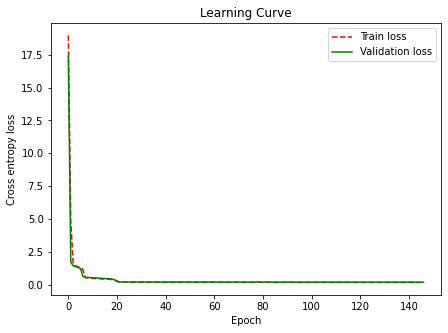


 Test AUC is 0.7790834903717041
+----------------------------+------------+
|          Modules           | Parameters |
+----------------------------+------------+
|   GNN1.linear_0_v.weight   |    290     |
|    GNN1.linear_0_v.bias    |     10     |
|   GNN1.linear_0_e.weight   |    190     |
|    GNN1.linear_0_e.bias    |     10     |
|   GNN1.linear_0_g.weight   |    2000    |
|    GNN1.linear_0_g.bias    |     10     |
|   GNN1.linear_e_0.weight   |    500     |
|    GNN1.linear_e_0.bias    |     10     |
|   GNN1.linear_e_1.weight   |    100     |
|    GNN1.linear_e_1.bias    |     10     |
|   GNN1.linear_m_0.weight   |    200     |
|   GNN1.linear_m_1.weight   |    100     |
|   GNN1.linear_v_0.weight   |    300     |
|    GNN1.linear_v_0.bias    |     10     |
|   GNN1.linear_v_1.weight   |    100     |
|    GNN1.linear_v_1.bias    |     10     |
|   GNN1.linear_r_0.weight   |    300     |
|    GNN1.linear_r_0.bias    |     10     |
|   GNN1.linear_r_1.weight   |    100     |

5363

In [ ]:
class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(29,19,200,10,10,10,10,10,10,10,10,10,1,10,10,num_layers=1)
        self.linear = nn.Linear(10, 12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('linear')
        nn.init.xavier_normal_(self.linear.weight, gain=gain) 
    def forward(self, mol_dgl_graph,fg):
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.sigmoid(self.linear(output))   
      return output
model= GNN().to(device)
count_parameters(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses = train_model(model, batch_size=64, optimizer=optimizer, patience=25, n_epochs=200)
count_parameters(model)

[ 26/200] train_loss: 0.16104 valid_loss: 0.18744
EarlyStopping counter: 20 out of 20
Early Stopping

 Training Time was 353.39434480667114 seconds in cpu




<Figure size 504x360 with 0 Axes>

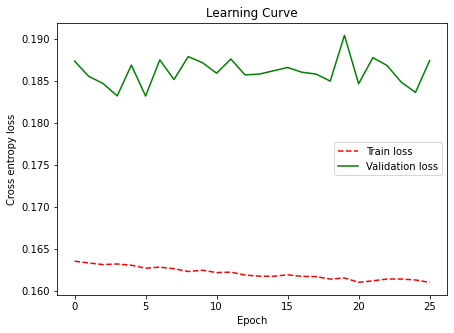


 Test AUC is 0.7771264712015787
+----------------------------+------------+
|          Modules           | Parameters |
+----------------------------+------------+
|   GNN1.linear_0_v.weight   |    290     |
|    GNN1.linear_0_v.bias    |     10     |
|   GNN1.linear_0_e.weight   |    190     |
|    GNN1.linear_0_e.bias    |     10     |
|   GNN1.linear_0_g.weight   |    2000    |
|    GNN1.linear_0_g.bias    |     10     |
|   GNN1.linear_e_0.weight   |    500     |
|    GNN1.linear_e_0.bias    |     10     |
|   GNN1.linear_e_1.weight   |    100     |
|    GNN1.linear_e_1.bias    |     10     |
|   GNN1.linear_m_0.weight   |    200     |
|   GNN1.linear_m_1.weight   |    100     |
|   GNN1.linear_v_0.weight   |    300     |
|    GNN1.linear_v_0.bias    |     10     |
|   GNN1.linear_v_1.weight   |    100     |
|    GNN1.linear_v_1.bias    |     10     |
|   GNN1.linear_r_0.weight   |    300     |
|    GNN1.linear_r_0.bias    |     10     |
|   GNN1.linear_r_1.weight   |    100     |

5363

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
model, train_losses, val_losses = train_model(model, batch_size=8, optimizer=optimizer, patience=20, n_epochs=200)
count_parameters(model)

[50/50] train_loss: 0.18618 valid_loss: 0.19433
EarlyStopping counter: 1 out of 25

 Training Time was 338.45793628692627 seconds in cpu




<Figure size 504x360 with 0 Axes>

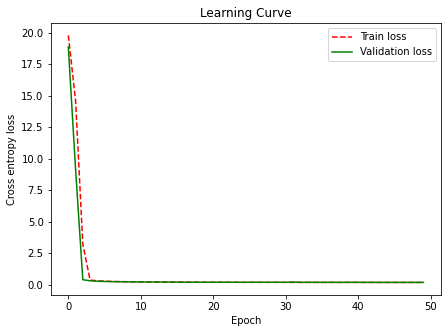


 Test AUC is 0.7760140101114908
+----------------------------+------------+
|          Modules           | Parameters |
+----------------------------+------------+
|   GNN1.linear_0_v.weight   |    145     |
|    GNN1.linear_0_v.bias    |     5      |
|   GNN1.linear_0_e.weight   |     95     |
|    GNN1.linear_0_e.bias    |     5      |
|   GNN1.linear_0_g.weight   |    1000    |
|    GNN1.linear_0_g.bias    |     5      |
|   GNN1.linear_e_0.weight   |    125     |
|    GNN1.linear_e_0.bias    |     5      |
|   GNN1.linear_e_1.weight   |     25     |
|    GNN1.linear_e_1.bias    |     5      |
|   GNN1.linear_m_0.weight   |     50     |
|   GNN1.linear_m_1.weight   |     25     |
|   GNN1.linear_v_0.weight   |     75     |
|    GNN1.linear_v_0.bias    |     5      |
|   GNN1.linear_v_1.weight   |     25     |
|    GNN1.linear_v_1.bias    |     5      |
|   GNN1.linear_r_0.weight   |     75     |
|    GNN1.linear_r_0.bias    |     5      |
|   GNN1.linear_r_1.weight   |     25     |

2038

In [ ]:
class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(29,19,200,5,5,5,5,5,5,5,5,5,1,5,5,num_layers=1)
        self.linear = nn.Linear(5, 12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('linear')
        nn.init.xavier_normal_(self.linear.weight, gain=gain) 
    def forward(self, mol_dgl_graph,fg):
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.sigmoid(self.linear(output))   
      return output
model= GNN().to(device)
count_parameters(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses = train_model(model, batch_size=32, optimizer=optimizer, patience=25, n_epochs=50)
count_parameters(model)

[ 81/150] train_loss: 0.17308 valid_loss: 0.18678
EarlyStopping counter: 25 out of 25
Early Stopping

 Training Time was 465.97318983078003 seconds in cpu




<Figure size 504x360 with 0 Axes>

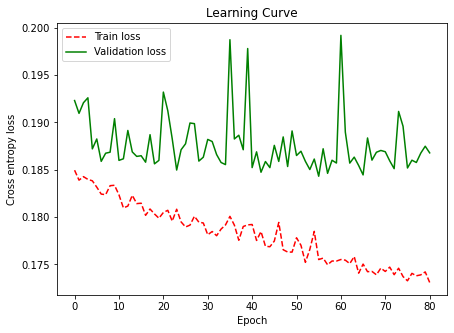


 Test AUC is 0.772316058476766


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses = train_model(model, batch_size=64, optimizer=optimizer, patience=25, n_epochs=150)

In [ ]:
train_dataloader, val_dataloader, test_dataloader  = loader(1)
for i, (smiles, mol_dgl_graph, globalss, labels, masks) in enumerate(train_dataloader):
  if i == 1:
    break
i=model.GNN1(mol_dgl_graph.to(device), globalss.to(device))
i[2]

tensor([[  1.0000,   1.0000,   1.0000,   1.0000,   1.0000,   1.0000,   1.0000,
           1.0000,   1.0000,   1.0000,   1.0000,   1.0000,   1.0000,   1.0000,
           1.0000,   1.0000,   1.0000,   1.0000],
        [251.3983, 259.3175, 247.1281, 261.3028, 267.0533, 244.8613, 258.2397,
         258.6144, 269.3223, 247.8740, 258.8043, 258.0320, 269.2490, 246.4944,
         263.5461, 242.0502, 253.2959, 256.2663]], grad_fn=<CatBackward>)

In [ ]:
nn.functional.relu(nn.functional.tanh(torch.Tensor([2.1])))

tensor([0.9705])

In [ ]:
# Data Generation 

def bond_is_in_ring_list_one_hot(bond, allowable_set=None, encode_unknown=False):
          list = [3,4,5] # List denotes the size of cycles
          return [bond.IsInRing()]+[bond.IsInRingSize(i) for i in list]

class CanonicalBondFeaturizer(fs.BaseBondFeaturizer):
       def __init__(self, bond_data_field='e', self_loop=False):
        super(CanonicalBondFeaturizer, self).__init__(
            featurizer_funcs={bond_data_field: fs.ConcatFeaturizer(
                [fs.bond_type_one_hot,
                 fs.bond_is_conjugated,
                 fs.bond_is_in_ring,
                 fs.bond_stereo_one_hot,
                 fs.bond_direction_one_hot,
                 bond_is_in_ring_list_one_hot
                 ]
            )}, self_loop=self_loop)
        
CanonicalBondFeaturizer = CanonicalBondFeaturizer()

# Tox21_dataset = pd.read_csv('https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/tox21.csv.gz', compression='gzip').fillna(0)

# Edge_features=[]
# no_edge=[]
# for i in range(Tox21_dataset.smiles.size):
#   try:
#     Edge_features.append(CanonicalBondFeaturizer(Chem.MolFromSmiles(Tox21_dataset.smiles[i]))['e'])
#   except:
#     no_edge.append(i)
#     Edge_features.append('no_edge')

# Tox21_dataset.drop(no_edge, inplace=True)

# for i in range(len(no_edge)):
#   del Edge_features[no_edge[i]-i]

# %cd /content/

# if not os.path.exists("/content/tox21-global-cdf-rdkit.csv"):
#   !unzip '/content/drive/MyDrive/GMLG_Research/Tox_21_Final/tox21-global-cdf-rdkit.zip'
#   !unzip '/content/drive/MyDrive/GMLG_Research/Tox_21_Final/Node_features_AF_NOH.zip'

# global_fetures = torch.Tensor(pd.read_csv('tox21-global-cdf-rdkit.csv').iloc[:,1:].values)
# with open('Node_features_AF_NOH.pickle', 'rb') as handle:
#     Node_features = pickle.load(handle)
1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.# for i in range(len(no_edge)):
#   del Node_features[no_edge[i]-i]

# for i in range(len(no_edge)):
#   global_fetures = global_fetures [torch.arange(global_fetures.size (0))!= no_edge[i] - i]

class DGLDatasetTox(torch.utils.data.Dataset):

    def __init__(self):

        Tox21_dataset1 = pd.read_csv('https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/tox21.csv.gz', compression='gzip').fillna(0)
        
        Edge_features=[]
        no_edge=[]
        for i in range(Tox21_dataset1.smiles.size):
          try:
            Edge_features.append(CanonicalBondFeaturizer(Chem.MolFromSmiles(Tox21_dataset1.smiles[i]))['e'])
          except:
            no_edge.append(i)
            Edge_features.append('no_edge')
        
        Tox21_dataset1.drop(no_edge, inplace=True)
        Tox21_dataset1.reset_index(drop=True)
        Tox21_dataset = Tox21_dataset1

        for i in range(len(no_edge)):
          del Edge_features[no_edge[i]-i]

        %cd /content/

        if not os.path.exists("/content/tox21-global-cdf-rdkit.csv"):
          !unzip '/content/drive/MyDrive/GMLG_Research/Tox_21_Final/tox21-global-cdf-rdkit.zip'
          !unzip '/content/drive/MyDrive/GMLG_Research/Tox_21_Final/Node_Features_AF3_NOH.zip'

        global_fetures = torch.Tensor(pd.read_csv('tox21-global-cdf-rdkit.csv').fillna(0).iloc[:,1:].values)
        # buffer=np.array(pd.read_csv('tox21-global-cdf-rdkit.csv').fillna(0).iloc[:,1:].values)
        # global_fetures = torch.from_numpy(buffer) # 101 NaN: should be addrressed correctly
        
        with open('Node_Features_AF3_NOH.pickle', 'rb') as handle:
            Node_features = pickle.load(handle)
        Node_features[1910][1][-3] = 1.1 # problem with the atom
        for i in range(len(no_edge)):
          del Node_features[no_edge[i]-i]

        for i in range(len(no_edge)):
          global_fetures = global_fetures [torch.arange(global_fetures.size (0))!= no_edge[i] - i]

        self.dgl_graphs = []
        for i in range(len(Node_features)):
          mol = Chem.MolFromSmiles(Tox21_dataset.iloc[i,-1])
          self.dgl_graphs.append(dgllife.utils.mol_to_bigraph(mol, canonical_atom_order=False))
          self.dgl_graphs[i].ndata['h_0'] = Node_features[i]
          self.dgl_graphs[i].edata['e_0'] = Edge_features[i]

        self.smiles = []
        #Tox21_dataset.iloc[:,13]
        for o in range(len(self.dgl_graphs)):
          self.smiles.append(Tox21_dataset.iloc[o,13])

        self.global_fetures = global_fetures
        self.labels = Tox21_dataset.iloc[:,:12].values
        self.masks = Tox21_dataset.replace({0: 1}).iloc[:,:12].values        
        
        # # Unzip the dataset and read its csv file, and fill in NaN values with 0
        # self.csv = pd.read_csv(csv_url, compression='gzip').fillna(0) 

        # # Make masks for labels (0 as NaN value, and 1 as other values)
        # self.masks_csv = pd.read_csv(csv_url, compression='gzip').replace({0: 1}).fillna(0)

        # # Split smiles, labels, and masks columns as lists
        # self.smiles = self.csv.iloc[:,13]
        # self.labels = self.csv.iloc[:,:12].values
        # self.masks = self.masks_csv.iloc[:,:12].values 

    def __len__(self):
        return len(self.dgl_graphs)

    def __getitem__(self, idx):
        return  self.smiles[idx], self.dgl_graphs[idx], self.global_fetures[idx], torch.Tensor(self.labels[idx]), torch.Tensor(self.masks[idx])
        #return  self.dgl_graphs[idx], self.global_fetures[idx], torch.Tensor(self.labels[idx]), torch.Tensor(self.masks[idx])
        
dataset = DGLDatasetTox()

# Train, validation, and test set split
train_set, val_set, test_set = dgllife.utils.ScaffoldSplitter.train_val_test_split(dataset, frac_val=0.1, frac_test=0.1)

def collate(batch):
    # batch is a list of triples (graphs, labels, masks)
    # Concatenate a sequence of graphs
    
    smiles = [e[0] for e in batch]
    
    graphs = [e[1] for e in batch]
    g = dgl.batch(graphs)

    gf = [e[2] for e in batch]
    gf = torch.stack(gf, 0)

    # Concatenate a sequence of tensors (labels) along a new dimension
    labels = [e[3] for e in batch]
    labels = torch.stack(labels, 0)

    # Concatenate a sequence of tensors (masks) along a new dimension
    masks = [e[4] for e in batch]
    masks = torch.stack(masks, 0)

    return smiles, g, gf, labels, masks

def loader(batch_size=64):

    train_dataloader = DataLoader(train_set,
                              batch_size=batch_size,
                              collate_fn=collate,
                              drop_last=False,
                              shuffle=True)

    val_dataloader =  DataLoader(val_set,
                             batch_size=batch_size,
                             collate_fn=collate,
                             drop_last=False,
                             shuffle=False)

    test_dataloader = DataLoader(test_set,
                             batch_size=batch_size,
                             collate_fn=collate,
                             drop_last=False,
                             shuffle=False)
    
    return train_dataloader, val_dataloader, test_dataloader

# borrowed form: https://stackoverflow.com/a/62508086
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
#count_parameters(model)

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

def my_loss(output, label, mask=None):
    criterion = nn.BCELoss(reduction='none')
    if mask == None:
        loss = torch.sum(torch.mean(criterion(output,label), axis=1))
    else: 
        loss = torch.sum(torch.mean(mask*criterion(output,label), axis=1))
    return loss 

def train_model(model, batch_size, optimizer, patience=10, n_epochs=1):
    #metric=AUROC()
    metric = roc_auc_score
    train_dataloader, val_dataloader, test_dataloader  = loader(batch_size)
    train_losses = []
    val_losses = []
    early_stopping = EarlyStopping(patience=patience, verbose=True) # initialize the early_stopping object
    start_time = time.time()
    #optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(1, n_epochs+1):
        epoch_train_loss = 0
        epoch_val_loss = 0
        
        model.train() #Prepare model for training
        for i, (_, mol_dgl_graph, fg, labels, masks) in enumerate(train_dataloader):
            mol_dgl_graph=mol_dgl_graph.to(device)
            labels=labels.to(device)
            masks=masks.to(device)
            fg=fg.to(device)
            prediction = model(mol_dgl_graph, fg)
            loss_train = my_loss(prediction, labels, masks)
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()
            epoch_train_loss += loss_train.detach().item()
        epoch_train_loss /= (len(train_set))
        train_losses.append(epoch_train_loss)

        model.eval() #Prepare model for evaluation
        for i, (_, mol_dgl_graph, fg, labels, masks) in enumerate(val_dataloader):
              mol_dgl_graph=mol_dgl_graph.to(device)
              labels=labels.to(device)
              masks=masks.to(device)
              fg=fg.to(device)
              prediction = model(mol_dgl_graph, fg)
              loss_val = my_loss(prediction, labels, masks)
              epoch_val_loss += loss_val.detach().item()
        epoch_val_loss /= (len(val_set))
        epoch_len = len(str(n_epochs))
        clear_output()
        print(f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {epoch_train_loss:.5f} ' +
                     f'valid_loss: {epoch_val_loss:.5f}')
        '''
        early_stopping needs the validation loss to check if it has decreased, 
        and if it has, it will make a checkpoint of the current model
        '''
        early_stopping(epoch_val_loss, model)
        val_losses.append(epoch_val_loss)
        if early_stopping.early_stop:
            print("Early Stopping")
            break

    print('\n Training Time was', time.time()-start_time, 'seconds in', device)
    model.load_state_dict(torch.load('checkpoint.pt')) #load the last checkpoint with the best model

    print('\n')
    ##Learning Curve
    plt.figure(figsize=(7,5))
    plt.figure(figsize=(7,5))
    # Draw lines
    plt.plot(range(len(train_losses)), train_losses, '--', color="red",  label="Train loss")
    plt.plot(range(len(val_losses)), val_losses, color="green", label="Validation loss")
    # Create plot
    plt.title("Learning Curve")
    plt.xlabel("Epoch"), plt.ylabel("Cross entropy loss"), plt.legend(loc="best")
    plt.show()
 
    with torch.no_grad():
        iter = 0
        prediction_all= torch.empty(0, device=device)
        labels_all= torch.empty(0, device=device)
        masks_all= torch.empty(0, device=device)
        for i, (_, mol_dgl_graph, fg, labels, masks) in enumerate(test_dataloader):
            mol_dgl_graph=mol_dgl_graph.to(device)
            labels=labels.to(device)
            masks=masks.to(device)
            fg=fg.to(device)
            prediction = model(mol_dgl_graph, fg)
            prediction_all = torch.cat((prediction_all, prediction), 0)
            labels_all = torch.cat((labels_all, labels), 0)
            masks_all = torch.cat((masks_all, labels), 0)
        average = torch.tensor([0.], device=device)
        for i in range(12):
          #average += metric(prediction_all[:, i].view(-1), labels_all[:, i].view(-1).int()) with pytorch-lightening
          average += metric(labels_all[:, i].view(-1).int().to('cpu'), prediction_all[:, i].view(-1).to('cpu')) 
    print('\n Test AUC is', average.item()/12)

    return  model, train_losses, val_losses 

/content
Start initializing RDKit molecule instances...
Creating RDKit molecule instance 1000/7812
Creating RDKit molecule instance 2000/7812
Creating RDKit molecule instance 3000/7812
Creating RDKit molecule instance 4000/7812
Creating RDKit molecule instance 5000/7812
Creating RDKit molecule instance 6000/7812
Creating RDKit molecule instance 7000/7812
Start computing Bemis-Murcko scaffolds.
Computing Bemis-Murcko for compound 1000/7812
Computing Bemis-Murcko for compound 2000/7812
Computing Bemis-Murcko for compound 3000/7812
Computing Bemis-Murcko for compound 4000/7812
Computing Bemis-Murcko for compound 5000/7812
Computing Bemis-Murcko for compound 6000/7812
Computing Bemis-Murcko for compound 7000/7812


In [ ]:
for i in range(len(dataset)):
  clear_output()
  print(i)
  dataset[95]


7811


In [ ]:
#torch.Tensor(.fillna(0).iloc[:,1:].values)

In [ ]:
df.fillna(df.mean())

In [ ]:
df.mean()

('RDKit2DNormalized_calculated', <class 'bool'>)    1.000000
('BalabanJ', <class 'numpy.float64'>)               0.785034
('BertzCT', <class 'numpy.float64'>)                0.167574
('Chi0', <class 'numpy.float64'>)                   0.200821
('Chi0n', <class 'numpy.float64'>)                  0.206498
                                                      ...   
('fr_thiocyan', <class 'numpy.float64'>)            0.001532
('fr_thiophene', <class 'numpy.float64'>)           0.010727
('fr_unbrch_alkane', <class 'numpy.float64'>)       0.135359
('fr_urea', <class 'numpy.float64'>)                0.188875
('qed', <class 'numpy.float64'>)                    0.455605
Length: 201, dtype: float64

In [ ]:
df=pd.read_csv('tox21-global-cdf-rdkit.csv').fillna(df.mean())

In [ ]:
pd.read_csv('tox21-global-cdf-rdkit.csv').isna().any().values

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False,  True, False,  True,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [ ]:
[40,42,44,46]

In [ ]:
pd.read_csv('tox21-global-cdf-rdkit.csv').iloc[:,46].isna()

array([False, False, False, ..., False, False, False])

In [ ]:
pd.read_csv('tox21-global-cdf-rdkit.csv').iloc[:,46].mean()

0.5398425599357882

In [ ]:
pd.read_csv('tox21-global-cdf-rdkit.csv').iloc[:,40]


0       0.853856
1       0.126957
2       0.236297
3       0.126590
4       0.191146
          ...   
7826    0.698749
7827    0.102922
7828    0.244565
7829    0.956745
7830    0.844820
Name: ('MaxAbsPartialCharge', <class 'numpy.float64'>), Length: 7831, dtype: float64

In [ ]:
train_dataloader, val_dataloader, test_dataloader  = loader(1)
for i, (smiles, mol_dgl_graph, globalss, labels, masks) in enumerate(train_dataloader):
  dataset[0]
  clear_output()
  print(i)

94


KeyError: ignored

In [ ]:
len(dataset)

7812

In [ ]:
dataset[0]

('CCOc1ccc2nc(S(N)(=O)=O)sc2c1', Graph(num_nodes=16, num_edges=34,
       ndata_schemes={'h_0': Scheme(shape=(29,), dtype=torch.float32)}
       edata_schemes={'e_0': Scheme(shape=(19,), dtype=torch.float32)}), tensor([9.3480e-01, 1.7742e-01, 4.6765e-02, 3.3326e-02, 6.0566e-02, 3.9962e-02,
         2.9073e-02, 1.4143e-01, 2.4657e-02, 2.2856e-01, 2.5139e-02, 2.6805e-01,
         3.4317e-02, 2.8204e-01, 7.4264e-01, 4.5629e-01, 6.8936e-07, 1.7916e-01,
         5.0928e-01, 4.0866e-01, 9.2584e-11, 6.6747e-01, 4.7787e-01, 1.5833e-01,
         5.9151e-01, 7.7751e-02, 9.7443e-01, 9.7325e-01, 9.4047e-01, 2.7430e-01,
         9.2575e-01, 4.3509e-02, 8.7954e-02, 1.0000e+00, 4.9894e-02, 3.1270e-02,
         2.8189e-01, 4.3682e-02, 1.0464e-01, 8.5386e-01, 1.0464e-01, 5.3593e-01,
         4.1387e-01, 5.1533e-01, 4.1707e-02, 1.3269e-01, 1.1096e-01, 4.5542e-02,
         7.5736e-02, 7.0728e-01, 3.0517e-01, 9.9386e-22, 1.4249e-01, 6.2963e-02,
         3.5821e-01, 8.6504e-01, 3.8583e-01, 4.9226e-01, 4.74

In [ ]:
        buffer=np.array(pd.read_csv('tox21-global-cdf-rdkit.csv').fillna(0).iloc[:,1:].values)
        global_fetures = torch.from_numpy(buffer) # 101 NaN: should be addrressed correctly

In [ ]:
global_fetures.shape

torch.Size([7831, 200])

In [ ]:
class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(29,19,200,10,10,15,10,10,10,10,10,10,2,10,10)
        self.linear = nn.Linear(10, 12)
        self.reset_parameters()
        self.i=1
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('linear')
        nn.init.xavier_normal_(self.linear.weight, gain=gain) 
    def forward(self, mol_dgl_graph,fg):
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.sigmoid(self.linear(output))
      clear_output()
      self.i += 1
      print(self.i)#,fg)      
      return output
model= GNN().to(device)
count_parameters(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses = train_model(model, batch_size=1, optimizer=optimizer, patience=25, n_epochs=50)
count_parameters(model)

536


KeyError: ignored

In [ ]:
global_fetures_t = global_fetures_iii
#global_fee
nfn=[]
# Node_features_rrr[i].isnan().any()
for i in range(len(global_fetures_t )):
  if global_fetures_t [i].isnan().any() == True:
    nfn.append(i)

In [ ]:
global_fetures_iii = torch.Tensor(pd.read_csv('tox21-global-cdf-rdkit.csv').fillna(0).iloc[:,1:].values) # 101 NaN: should be addrressed correctly

In [ ]:
len(nfn)

0

In [ ]:
global_fetures_iii[3]

tensor([9.6758e-01, 5.9713e-02, 1.7813e-01, 3.0837e-01, 2.5721e-01, 1.3395e-01,
        2.9016e-01, 2.2136e-01, 2.3168e-01, 1.5390e-01, 2.7137e-01, 1.8217e-01,
        3.0554e-01, 2.0713e-01, 4.0749e-10, 2.6487e-01, 6.8936e-07, 4.2420e-01,
        1.9674e-02, 8.4760e-01, 9.2584e-11, 5.8561e-17, 6.5958e-01, 7.7466e-01,
        7.5225e-13, 1.1243e-01, 7.1569e-01, 4.4008e-01, 1.9227e-01, 8.4676e-01,
        9.0475e-01, 1.3706e-01, 8.7870e-02, 1.0000e+00, 3.2919e-01, 4.9647e-01,
        5.1656e-01, 1.5603e-01, 4.1565e-01, 1.2659e-01, 4.1565e-01, 3.4639e-01,
        2.7092e-01, 3.3832e-01, 7.2101e-01, 8.6413e-01, 5.9004e-01, 2.3054e-01,
        1.0932e-01, 4.3608e-01, 1.2405e-01, 9.9386e-22, 1.4249e-01, 6.2963e-02,
        3.5821e-01, 4.8299e-15, 8.3758e-02, 8.4739e-02, 4.7447e-01, 3.3458e-02,
        5.6952e-08, 5.8913e-01, 0.0000e+00, 1.1424e-21, 2.4025e-23, 1.9532e-01,
        1.3928e-01, 5.7614e-21, 3.6088e-15, 8.4236e-01, 1.7356e-22, 1.1809e-10,
        6.2375e-01, 9.0550e-08, 4.6098e-

In [ ]:
model= GNN()

In [ ]:
model(mol_dgl_graph, torch.randn(2,200))

tensor([[0.4313, 0.5162, 0.2845, 0.4855, 0.4663, 0.6013, 0.3927, 0.3094, 0.5100,
         0.2588, 0.8410, 0.5903],
        [0.4470, 0.5034, 0.3243, 0.6104, 0.3730, 0.5952, 0.3580, 0.2869, 0.4645,
         0.1997, 0.8936, 0.6568]], grad_fn=<SigmoidBackward>)

In [ ]:
dgl.unbatch(mol_dgl_graph)



[Graph(num_nodes=29, num_edges=66,
       ndata_schemes={'h': Scheme(shape=(35,), dtype=torch.float32)}
       edata_schemes={'e': Scheme(shape=(19,), dtype=torch.float32)}),
 Graph(num_nodes=19, num_edges=36,
       ndata_schemes={'h': Scheme(shape=(35,), dtype=torch.float32)}
       edata_schemes={'e': Scheme(shape=(19,), dtype=torch.float32)})]

In [ ]:
mol_dgl_graph.ndata['h_0'] =mol_dgl_graph.ndata['h']
mol_dgl_graph.edata['e_0'] =mol_dgl_graph.edata['e']

In [ ]:
fg

NameError: ignored

In [ ]:
molecular_graph

NameError: ignored

In [ ]:
a=(1,2)
a[1]

2

In [ ]:
        with open('Node_Features_AF3_NOH.pickle', 'rb') as handle:
            Node_features = pickle.load(handle)

        Node_features[1910][1][-3] = 1.1 # problem with the atom
        for i in range(len(no_edge)):
          del Node_features[no_edge[i]-i]


In [ ]:
        if not os.path.exists("/content/tox21-global-cdf-rdkit.csv"):
          !unzip '/content/drive/MyDrive/GMLG_Research/Tox_21_Final/tox21-global-cdf-rdkit.zip'
          !unzip '/content/drive/MyDrive/GMLG_Research/Tox_21_Final/Node_features_AF3_NOH.zip'

        global_fetures = torch.Tensor(pd.read_csv('tox21-global-cdf-rdkit.csv').iloc[:,1:].values)
        with open('Node_features_AF_NOH.pickle', 'rb') as handle:
            Node_features = pickle.load(handle)

        for i in range(len(no_edge)):
          del Node_features[no_edge[i]-i]

        for i in range(len(no_edge)):
          global_fetures = global_fetures [torch.arange(global_fetures.size (0))!= no_edge[i] - i]

In [ ]:
!unzip '/content/drive/MyDrive/GMLG_Research/Tox_21_Final/Node_Features_AF3_NOH.zip'

Archive:  /content/drive/MyDrive/GMLG_Research/Tox_21_Final/Node_Features_AF3_NOH.zip
  inflating: Node_Features_AF3_NOH.pickle  


In [ ]:
with open('Node_Features_AF3_NOH.pickle', 'rb') as handle:
  Node_features_rrr = pickle.load(handle)

In [ ]:
Node_features_rrr[5920].isnan().any() 

tensor(False)

In [ ]:
nfn=[]
# Node_features_rrr[i].isnan().any()
for i in range(len(Node_features_rrr)):
  if Node_features_rrr[i].isnan().any() == True:
    nfn.append(i)

In [ ]:
nfn

[]

In [ ]:
Node_features_rrr[1910][1][-3] = 1.1

In [ ]:
Node_features_rrr[1910][1].dtype

torch.float32

In [ ]:
len(Node_features_rrr)

7831

In [ ]:
torch.isnan(Node_features_rrr)

TypeError: ignored

In [ ]:
#5920

In [ ]:
smiles

['O=c1oc2ccccc2c(O)c1C(CC(O)c1ccc(-c2ccc(Br)cc2)cc1)c1ccccc1',
 'CN[C@]1(c2ccccc2Cl)CCCCC1=O']

In [ ]:
mol_dgl_graph

Graph(num_nodes=48, num_edges=102,
      ndata_schemes={'h': Scheme(shape=(35,), dtype=torch.float32)}
      edata_schemes={'e': Scheme(shape=(19,), dtype=torch.float32)})

In [ ]:
globalss.shape

torch.Size([2, 200])

In [ ]:
a=loader(10)

In [ ]:
len(dataset)

7812

In [ ]:
dataset[44]

(Graph(num_nodes=35, num_edges=74,
       ndata_schemes={'h': Scheme(shape=(35,), dtype=torch.float32)}
       edata_schemes={'e': Scheme(shape=(19,), dtype=torch.float32)}),
 tensor([5.4396e-01, 7.4329e-01, 8.2981e-01, 7.4806e-01, 7.5956e-01, 7.8730e-01,
         7.0337e-01, 6.7628e-01, 6.8765e-01, 6.4954e-01, 5.6197e-01, 5.1163e-01,
         4.7578e-01, 4.1957e-01, 9.0918e-01, 8.8307e-01, 6.8936e-07, 5.4500e-01,
         4.8583e-01, 4.5767e-01, 9.2584e-11, 9.5350e-01, 6.2212e-01, 1.6919e-01,
         8.5199e-01, 8.2135e-01, 2.9491e-01, 2.6821e-01, 2.2057e-01, 2.8716e-01,
         1.8107e-01, 8.0372e-01, 8.3532e-01, 1.0000e+00, 8.4582e-01, 8.2452e-01,
         7.7973e-01, 8.0031e-01, 5.9248e-01, 5.3282e-01, 5.9248e-01, 9.5812e-01,
         6.3294e-01, 9.6714e-01, 3.3499e-02, 4.5586e-01, 9.8468e-01, 7.3911e-01,
         8.2640e-01, 4.3608e-01, 3.0517e-01, 9.9386e-22, 1.4249e-01, 6.2963e-02,
         9.6401e-01, 4.8299e-15, 6.1776e-01, 4.9226e-01, 4.7447e-01, 7.2707e-01,
         5.6952

In [ ]:
Tox21_dataset.iloc[95,-1]

'O=C(C=Cc1ccc(O)c(O)c1)O[C@@H]1C[C@](O)(C(=O)O)C[C@@H](O)[C@H]1O'

In [ ]:
Tox21_dataset1 = pd.read_csv('https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/tox21.csv.gz', compression='gzip').fillna(0)

In [ ]:
Tox21_dataset1.iloc[95,-1]

'[I-].[K+]'

In [ ]:
Edge_features4 = []
no_edge2 = []
for i in range(Tox21_dataset.smiles.size):
  try:
    Edge_features4.append(CanonicalBondFeaturizer(Chem.MolFromSmiles(Tox21_dataset.iloc[i,-1]))['e'])
  except:
    no_edge2.append(i)
    Edge_features4.append('no_edge')
no_edge2

RDKit WARNING: [05:42:10] WARNING: not removing hydrogen atom without neighbors


[]

In [ ]:
global_fetures.shape

torch.Size([7831, 200])

In [ ]:
global_fetures[global_fetures.shape[0] != no_edge[0]].shape

torch.Size([1, 7831, 200])

In [ ]:
global_fetures.shape[0]

7831

In [ ]:
del Node_features[no_edge[:]]

TypeError: ignored

In [ ]:
a=[1, 2, 3]

In [ ]:
b=[1,3]

In [ ]:
del a[]

SyntaxError: ignored

In [ ]:
Node_features_t=Node_features
for i in range(len(no_edge)):
  del Node_features_t[no_edge[i]-i]

In [ ]:
len(Node_features_t)

7812

In [ ]:
Node_features_t[2000].shape

torch.Size([14, 35])

In [ ]:
Tox21_dataset.smiles[2000]

'NC[C@H](O)c1ccc(O)c(O)c1'

In [ ]:
d

In [ ]:
[b[i] for i in range(len(b))]

[1, 3]

In [ ]:
no_edge

[95,
 255,
 659,
 985,
 1423,
 1534,
 1722,
 1933,
 2147,
 2251,
 2760,
 2832,
 4024,
 4375,
 4611,
 5942,
 6477,
 6547,
 6717]

In [ ]:
global_fetures_t = global_fetures
for i in range(len(no_edge)):
  global_fetures_t = global_fetures_t [torch.arange(global_fetures_t.size (0))!= no_edge[i] - i]

In [ ]:
global_fetures[96]

tensor([7.8768e-01, 2.4634e-01, 4.3818e-01, 2.6088e-01, 2.1302e-01, 3.1764e-01,
        2.4809e-01, 1.8494e-01, 3.2575e-01, 2.2957e-01, 3.0745e-01, 2.1067e-01,
        2.7184e-01, 1.8122e-01, 9.4408e-01, 9.7040e-01, 6.8936e-07, 4.0748e-01,
        1.3185e-01, 1.6119e-01, 8.9477e-01, 5.8561e-17, 1.0887e-06, 2.3915e-11,
        5.9031e-01, 3.5931e-01, 6.3721e-01, 5.1141e-01, 3.8813e-01, 5.2893e-01,
        5.5454e-01, 3.6230e-01, 3.6804e-01, 1.0000e+00, 4.8039e-01, 3.4835e-01,
        5.3841e-01, 2.9954e-01, 1.8773e-01, 9.3646e-01, 1.8773e-01, 8.5435e-01,
        8.8569e-01, 8.6204e-01, 7.1865e-02, 4.1180e-02, 2.0808e-02, 1.8962e-01,
        3.5428e-01, 9.6460e-01, 8.7595e-01, 9.9995e-01, 1.4249e-01, 5.0000e-01,
        3.5821e-01, 4.8299e-15, 8.3758e-02, 9.1034e-01, 9.6947e-01, 7.2707e-01,
        5.6952e-08, 2.1430e-01, 8.9543e-01, 1.1424e-21, 8.8066e-01, 4.0646e-01,
        9.6412e-01, 7.3202e-01, 9.9792e-01, 1.4598e-01, 1.7356e-22, 9.6111e-01,
        5.9983e-02, 7.9907e-01, 4.6098e-

In [ ]:
global_fetures_t[95]

tensor([7.8768e-01, 2.4634e-01, 4.3818e-01, 2.6088e-01, 2.1302e-01, 3.1764e-01,
        2.4809e-01, 1.8494e-01, 3.2575e-01, 2.2957e-01, 3.0745e-01, 2.1067e-01,
        2.7184e-01, 1.8122e-01, 9.4408e-01, 9.7040e-01, 6.8936e-07, 4.0748e-01,
        1.3185e-01, 1.6119e-01, 8.9477e-01, 5.8561e-17, 1.0887e-06, 2.3915e-11,
        5.9031e-01, 3.5931e-01, 6.3721e-01, 5.1141e-01, 3.8813e-01, 5.2893e-01,
        5.5454e-01, 3.6230e-01, 3.6804e-01, 1.0000e+00, 4.8039e-01, 3.4835e-01,
        5.3841e-01, 2.9954e-01, 1.8773e-01, 9.3646e-01, 1.8773e-01, 8.5435e-01,
        8.8569e-01, 8.6204e-01, 7.1865e-02, 4.1180e-02, 2.0808e-02, 1.8962e-01,
        3.5428e-01, 9.6460e-01, 8.7595e-01, 9.9995e-01, 1.4249e-01, 5.0000e-01,
        3.5821e-01, 4.8299e-15, 8.3758e-02, 9.1034e-01, 9.6947e-01, 7.2707e-01,
        5.6952e-08, 2.1430e-01, 8.9543e-01, 1.1424e-21, 8.8066e-01, 4.0646e-01,
        9.6412e-01, 7.3202e-01, 9.9792e-01, 1.4598e-01, 1.7356e-22, 9.6111e-01,
        5.9983e-02, 7.9907e-01, 4.6098e-

In [ ]:
global_fetures_t.shape

torch.Size([7812, 200])

In [ ]:
a=torch.rand (4, 2)
print (a)
idx=1
a=a [torch.arange(a.size (0))!= ]
print (a)

tensor([[0.5661, 0.3715],
        [0.1229, 0.1732],
        [0.2283, 0.2710],
        [0.0262, 0.2113]])
tensor([[0.5661, 0.3715],
        [0.2283, 0.2710],
        [0.0262, 0.2113]])


In [ ]:
torch.arange(a.size (0))

tensor([0, 1, 2])

In [ ]:
torch.tensor(no_edge)

tensor([  95,  255,  659,  985, 1423, 1534, 1722, 1933, 2147, 2251, 2760, 2832,
        4024, 4375, 4611, 5942, 6477, 6547, 6717])

In [ ]:
no_edge[0]

95

In [ ]:
Tox21_dataset.iloc[95,-1]

'[I-].[K+]'

In [ ]:
no_edge

[95,
 255,
 659,
 985,
 1423,
 1534,
 1722,
 1933,
 2147,
 2251,
 2760,
 2832,
 4024,
 4375,
 4611,
 5942,
 6477,
 6547,
 6717]

In [ ]:
Tox21_dataset

,NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,SR-MMP,SR-p53,mol_id,smiles
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,TOX3021,CCOc1ccc2nc(S(N)(=O)=O)sc2c1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TOX3020,CCN1C(=O)NC(c2ccccc2)C1=O
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TOX3024,CC[C@]1(O)CC[C@H]2[C@@H]3CCC4=CCCC[C@@H]4[C@H]...
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TOX3027,CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TOX20800,CC(O)(P(=O)(O)O)P(=O)(O)O
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7826,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TOX2725,CCOc1nc2cccc(C(=O)O)c2n1Cc1ccc(-c2ccccc2-c2nnn...
7827,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TOX2370,CC(=O)[C@H]1CC[C@H]2[C@@H]3CCC4=CC(=O)CC[C@]4(...
7828,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,TOX2371,C[C@]12CC[C@H]3[C@@H](CCC4=CC(=O)CC[C@@]43C)[C...
7829,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,TOX2377,C[C@]12CC[C@@H]3c4ccc(O)cc4CC[C@H]3[C@@H]1CC[C...


In [ ]:
Tox21_dataset = Tox21_dataset.drop(no_edge)

In [ ]:
Tox21_dataset.drop(no_edge, inplace=True)

KeyError: ignored

In [ ]:
Tox21_dataset

,NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,SR-MMP,SR-p53,mol_id,smiles
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,TOX3021,CCOc1ccc2nc(S(N)(=O)=O)sc2c1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TOX3020,CCN1C(=O)NC(c2ccccc2)C1=O
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TOX3024,CC[C@]1(O)CC[C@H]2[C@@H]3CCC4=CCCC[C@@H]4[C@H]...
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TOX3027,CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TOX20800,CC(O)(P(=O)(O)O)P(=O)(O)O
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7826,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TOX2725,CCOc1nc2cccc(C(=O)O)c2n1Cc1ccc(-c2ccccc2-c2nnn...
7827,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TOX2370,CC(=O)[C@H]1CC[C@H]2[C@@H]3CCC4=CC(=O)CC[C@]4(...
7828,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,TOX2371,C[C@]12CC[C@H]3[C@@H](CCC4=CC(=O)CC[C@@]43C)[C...
7829,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,TOX2377,C[C@]12CC[C@@H]3c4ccc(O)cc4CC[C@H]3[C@@H]1CC[C...


In [ ]:
Tox21_dataset.iloc[95,-1]

'O=C(C=Cc1ccc(O)c(O)c1)O[C@@H]1C[C@](O)(C(=O)O)C[C@@H](O)[C@H]1O'

In [ ]:
no_edge2=[]
Edge_features=[]
for i in range(Tox21_dataset.smiles.size):
  try:
    Edge_features.append(CanonicalBondFeaturizer(Chem.MolFromSmiles(Tox21_dataset.smiles[i]))['e'])
  except:
    no_edge2.append(i)
    Edge_features.append('no_edge')

RDKit WARNING: [21:03:38] WARNING: not removing hydrogen atom without neighbors


In [ ]:
len(Edge_features)

7812

In [ ]:
Tox21_dataset.smiles[94]

'Nc1ccc([N+](=O)[O-])cc1N'

In [ ]:
Chem.MolFromSmiles(Tox21_dataset.smiles[95])

KeyError: ignored

In [ ]:
no_edge2

[95,
 255,
 659,
 985,
 1423,
 1534,
 1722,
 1933,
 2147,
 2251,
 2760,
 2832,
 4024,
 4375,
 4611,
 5942,
 6477,
 6547,
 6717]

In [ ]:
Tox21_dataset.drop([1,2])

,NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,SR-MMP,SR-p53,mol_id,smiles
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,TOX3021,CCOc1ccc2nc(S(N)(=O)=O)sc2c1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TOX3027,CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TOX20800,CC(O)(P(=O)(O)O)P(=O)(O)O
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TOX5110,CC(C)(C)OOC(C)(C)CCC(C)(C)OOC(C)(C)C
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TOX6619,O=S(=O)(Cl)c1ccccc1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7826,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TOX2725,CCOc1nc2cccc(C(=O)O)c2n1Cc1ccc(-c2ccccc2-c2nnn...
7827,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TOX2370,CC(=O)[C@H]1CC[C@H]2[C@@H]3CCC4=CC(=O)CC[C@]4(...
7828,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,TOX2371,C[C@]12CC[C@H]3[C@@H](CCC4=CC(=O)CC[C@@]43C)[C...
7829,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,TOX2377,C[C@]12CC[C@@H]3c4ccc(O)cc4CC[C@H]3[C@@H]1CC[C...


In [ ]:
len(Tox21_dataset)

7831

In [ ]:
del(already_installed)

In [ ]:
ls '/content/drive/MyDrive/GMLG_Research/Tox_21_Final/'

Node_features_AF_NOH.zip  tox21-global-cdf-rdkit.zip


In [ ]:
%cd /content/

if not os.path.exists("/content/tox21-global-cdf-rdkit.csv"):
  !unzip '/content/drive/MyDrive/GMLG_Research/Tox_21_Final/tox21-global-cdf-rdkit.zip'
  !unzip '/content/drive/MyDrive/GMLG_Research/Tox_21_Final/Node_features_AF_NOH.zip'

global_fetures = torch.Tensor(pd.read_csv('tox21-global-cdf-rdkit.csv').iloc[:,1:].values)
with open('Node_features_AF_NOH.pickle', 'rb') as handle:
    Node_features = pickle.load(handle)

In [ ]:
pwd

'/content'

In [ ]:
!unzip '/content/drive/MyDrive/GMLG_Research/Tox_21_Final/tox21-global-cdf-rdkit.zip'


Archive:  /content/drive/MyDrive/GMLG_Research/Tox_21_Final/tox21-global-cdf-rdkit.zip
  inflating: tox21-global-cdf-rdkit.csv  


NameError: ignored

In [ ]:
!unzip '/content/drive/MyDrive/GMLG_Research/Tox_21_Final/Node_features_AF_NOH.zip'

Archive:  /content/drive/MyDrive/GMLG_Research/Tox_21_Final/Node_features_AF_NOH.zip
  inflating: Main_Featurizer.ipynb   
  inflating: Node_features_AF_NOH.pickle  


In [ ]:
ls

drive/  sample_data/  tox21-global-cdf-rdkit.csv


In [ ]:
pd=pd.read_csv('tox21-global-cdf-rdkit.csv')

In [ ]:
pd

,"('RDKit2DNormalized_calculated', <class 'bool'>)","('BalabanJ', <class 'numpy.float64'>)","('BertzCT', <class 'numpy.float64'>)","('Chi0', <class 'numpy.float64'>)","('Chi0n', <class 'numpy.float64'>)","('Chi0v', <class 'numpy.float64'>)","('Chi1', <class 'numpy.float64'>)","('Chi1n', <class 'numpy.float64'>)","('Chi1v', <class 'numpy.float64'>)","('Chi2n', <class 'numpy.float64'>)","('Chi2v', <class 'numpy.float64'>)","('Chi3n', <class 'numpy.float64'>)","('Chi3v', <class 'numpy.float64'>)","('Chi4n', <class 'numpy.float64'>)","('Chi4v', <class 'numpy.float64'>)","('EState_VSA1', <class 'numpy.float64'>)","('EState_VSA10', <class 'numpy.float64'>)","('EState_VSA11', <class 'numpy.float64'>)","('EState_VSA2', <class 'numpy.float64'>)","('EState_VSA3', <class 'numpy.float64'>)","('EState_VSA4', <class 'numpy.float64'>)","('EState_VSA5', <class 'numpy.float64'>)","('EState_VSA6', <class 'numpy.float64'>)","('EState_VSA7', <class 'numpy.float64'>)","('EState_VSA8', <class 'numpy.float64'>)","('EState_VSA9', <class 'numpy.float64'>)","('ExactMolWt', <class 'numpy.float64'>)","('FpDensityMorgan1', <class 'numpy.float64'>)","('FpDensityMorgan2', <class 'numpy.float64'>)","('FpDensityMorgan3', <class 'numpy.float64'>)","('FractionCSP3', <class 'numpy.float64'>)","('HallKierAlpha', <class 'numpy.float64'>)","('HeavyAtomCount', <class 'numpy.float64'>)","('HeavyAtomMolWt', <class 'numpy.float64'>)","('Ipc', <class 'numpy.float64'>)","('Kappa1', <class 'numpy.float64'>)","('Kappa2', <class 'numpy.float64'>)","('Kappa3', <class 'numpy.float64'>)","('LabuteASA', <class 'numpy.float64'>)","('MaxAbsEStateIndex', <class 'numpy.float64'>)",...,"('fr_hdrzone', <class 'numpy.float64'>)","('fr_imidazole', <class 'numpy.float64'>)","('fr_imide', <class 'numpy.float64'>)","('fr_isocyan', <class 'numpy.float64'>)","('fr_isothiocyan', <class 'numpy.float64'>)","('fr_ketone', <class 'numpy.float64'>)","('fr_ketone_Topliss', <class 'numpy.float64'>)","('fr_lactam', <class 'numpy.float64'>)","('fr_lactone', <class 'numpy.float64'>)","('fr_methoxy', <class 'numpy.float64'>)","('fr_morpholine', <class 'numpy.float64'>)","('fr_nitrile', <class 'numpy.float64'>)","('fr_nitro', <class 'numpy.float64'>)","('fr_nitro_arom', <class 'numpy.float64'>)","('fr_nitro_arom_nonortho', <class 'numpy.float64'>)","('fr_nitroso', <class 'numpy.float64'>)","('fr_oxazole', <class 'numpy.float64'>)","('fr_oxime', <class 'numpy.float64'>)","('fr_para_hydroxylation', <class 'numpy.float64'>)","('fr_phenol', <class 'numpy.float64'>)","('fr_phenol_noOrthoHbond', <class 'numpy.float64'>)","('fr_phos_acid', <class 'numpy.float64'>)","('fr_phos_ester', <class 'numpy.float64'>)","('fr_piperdine', <class 'numpy.float64'>)","('fr_piperzine', <class 'numpy.float64'>)","('fr_priamide', <class 'numpy.float64'>)","('fr_prisulfonamd', <class 'numpy.float64'>)","('fr_pyridine', <class 'numpy.float64'>)","('fr_quatN', <class 'numpy.float64'>)","('fr_sulfide', <class 'numpy.float64'>)","('fr_sulfonamd', <class 'numpy.float64'>)","('fr_sulfone', <class 'numpy.float64'>)","('fr_term_acetylene', <class 'numpy.float64'>)","('fr_tetrazole', <class 'numpy.float64'>)","('fr_thiazole', <class 'numpy.float64'>)","('fr_thiocyan', <class 'numpy.float64'>)","('fr_thiophene', <class 'numpy.float64'>)","('fr_unbrch_alkane', <class 'numpy.float64'>)","('fr_urea', <class 'numpy.float64'>)","('qed', <class 'numpy.float64'>)"
0,True,0.934799,0.177418,0.046765,0.033326,0.060566,0.039962,0.029073,0.141434,0.024657,0.228561,0.025139,0.268049,0.034317,0.282035,7.426378e-01,4.562858e-01,6.893569e-07,0.179159,0.509277,4.086641e-01,9.258417e-11,6.674678e-01,0.477870,1.583304e-01,5.915087e-01,0.077751,0.974430,0.973245,0.940471,0.274299,0.925753,0.043509,0.087954,0.999999,0.049894,0.031270,0.281892,0.043682,0.104644,...,0.168149,0.165451,1.171103e-13,0.0,0.164669,0.166925,0.000000,5.100713e-08,7.105427e-15,0.154654,2.794209e-22,0.0,0.16764,6.314993e-25,0.168186,0.009089,0.168363,8.265423e-11,0.156346,0.000000,0.000

In [ ]:
pd.iloc[:,1:].values

,"('BalabanJ', <class 'numpy.float64'>)","('BertzCT', <class 'numpy.float64'>)","('Chi0', <class 'numpy.float64'>)","('Chi0n', <class 'numpy.float64'>)","('Chi0v', <class 'numpy.float64'>)","('Chi1', <class 'numpy.float64'>)","('Chi1n', <class 'numpy.float64'>)","('Chi1v', <class 'numpy.float64'>)","('Chi2n', <class 'numpy.float64'>)","('Chi2v', <class 'numpy.float64'>)","('Chi3n', <class 'numpy.float64'>)","('Chi3v', <class 'numpy.float64'>)","('Chi4n', <class 'numpy.float64'>)","('Chi4v', <class 'numpy.float64'>)","('EState_VSA1', <class 'numpy.float64'>)","('EState_VSA10', <class 'numpy.float64'>)","('EState_VSA11', <class 'numpy.float64'>)","('EState_VSA2', <class 'numpy.float64'>)","('EState_VSA3', <class 'numpy.float64'>)","('EState_VSA4', <class 'numpy.float64'>)","('EState_VSA5', <class 'numpy.float64'>)","('EState_VSA6', <class 'numpy.float64'>)","('EState_VSA7', <class 'numpy.float64'>)","('EState_VSA8', <class 'numpy.float64'>)","('EState_VSA9', <class 'numpy.float64'>)","('ExactMolWt', <class 'numpy.float64'>)","('FpDensityMorgan1', <class 'numpy.float64'>)","('FpDensityMorgan2', <class 'numpy.float64'>)","('FpDensityMorgan3', <class 'numpy.float64'>)","('FractionCSP3', <class 'numpy.float64'>)","('HallKierAlpha', <class 'numpy.float64'>)","('HeavyAtomCount', <class 'numpy.float64'>)","('HeavyAtomMolWt', <class 'numpy.float64'>)","('Ipc', <class 'numpy.float64'>)","('Kappa1', <class 'numpy.float64'>)","('Kappa2', <class 'numpy.float64'>)","('Kappa3', <class 'numpy.float64'>)","('LabuteASA', <class 'numpy.float64'>)","('MaxAbsEStateIndex', <class 'numpy.float64'>)","('MaxAbsPartialCharge', <class 'numpy.float64'>)",...,"('fr_hdrzone', <class 'numpy.float64'>)","('fr_imidazole', <class 'numpy.float64'>)","('fr_imide', <class 'numpy.float64'>)","('fr_isocyan', <class 'numpy.float64'>)","('fr_isothiocyan', <class 'numpy.float64'>)","('fr_ketone', <class 'numpy.float64'>)","('fr_ketone_Topliss', <class 'numpy.float64'>)","('fr_lactam', <class 'numpy.float64'>)","('fr_lactone', <class 'numpy.float64'>)","('fr_methoxy', <class 'numpy.float64'>)","('fr_morpholine', <class 'numpy.float64'>)","('fr_nitrile', <class 'numpy.float64'>)","('fr_nitro', <class 'numpy.float64'>)","('fr_nitro_arom', <class 'numpy.float64'>)","('fr_nitro_arom_nonortho', <class 'numpy.float64'>)","('fr_nitroso', <class 'numpy.float64'>)","('fr_oxazole', <class 'numpy.float64'>)","('fr_oxime', <class 'numpy.float64'>)","('fr_para_hydroxylation', <class 'numpy.float64'>)","('fr_phenol', <class 'numpy.float64'>)","('fr_phenol_noOrthoHbond', <class 'numpy.float64'>)","('fr_phos_acid', <class 'numpy.float64'>)","('fr_phos_ester', <class 'numpy.float64'>)","('fr_piperdine', <class 'numpy.float64'>)","('fr_piperzine', <class 'numpy.float64'>)","('fr_priamide', <class 'numpy.float64'>)","('fr_prisulfonamd', <class 'numpy.float64'>)","('fr_pyridine', <class 'numpy.float64'>)","('fr_quatN', <class 'numpy.float64'>)","('fr_sulfide', <class 'numpy.float64'>)","('fr_sulfonamd', <class 'numpy.float64'>)","('fr_sulfone', <class 'numpy.float64'>)","('fr_term_acetylene', <class 'numpy.float64'>)","('fr_tetrazole', <class 'numpy.float64'>)","('fr_thiazole', <class 'numpy.float64'>)","('fr_thiocyan', <class 'numpy.float64'>)","('fr_thiophene', <class 'numpy.float64'>)","('fr_unbrch_alkane', <class 'numpy.float64'>)","('fr_urea', <class 'numpy.float64'>)","('qed', <class 'numpy.float64'>)"
0,0.934799,0.177418,0.046765,0.033326,0.060566,0.039962,0.029073,0.141434,0.024657,0.228561,0.025139,0.268049,0.034317,0.282035,7.426378e-01,4.562858e-01,6.893569e-07,0.179159,0.509277,4.086641e-01,9.258417e-11,6.674678e-01,0.477870,1.583304e-01,5.915087e-01,0.077751,0.974430,0.973245,0.940471,0.274299,0.925753,0.043509,0.087954,0.999999,0.049894,0.031270,0.281892,0.043682,0.104644,0.853856,...,0.168149,0.165451,1.171103e-13,0.0,0.164669,0.166925,0.000000,5.100713e-08,7.105427e-15,0.154654,2.794209e-22,0.0,0.16764,6.314993e-25,0.168186,0.009089,0.168363,8.265423e-11,0.156346,0.000000,0

In [ ]:
global_fetures = torch.Tensor(pd.iloc[:,1:].values)

In [ ]:
global_fetures.shape

torch.Size([7831, 200])

In [ ]:
ls

drive/                 Node_features_AF_NOH.pickle  tox21-global-cdf-rdkit.csv
Main_Featurizer.ipynb  sample_data/


In [ ]:
with open('Node_features_AF_NOH.pickle', 'rb') as handle:
    Node_features = pickle.load(handle)

In [ ]:
len(Node_features)

7831

In [ ]:
# borrowed form: https://stackoverflow.com/a/62508086
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(model)

+-----------------------+------------+
|        Modules        | Parameters |
+-----------------------+------------+
|   linear_0_v.weight   |    1580    |
|    linear_0_v.bias    |     10     |
|   linear_0_e.weight   |    160     |
|    linear_0_e.bias    |     10     |
|   linear_0_g.weight   |    200     |
|    linear_0_g.bias    |     10     |
|   linear_e_0.weight   |    500     |
|    linear_e_0.bias    |     10     |
|   linear_e_1.weight   |    100     |
|    linear_e_1.bias    |     10     |
|   linear_m_0.weight   |    200     |
|   linear_m_1.weight   |    100     |
|   linear_v_0.weight   |    300     |
|    linear_v_0.bias    |     10     |
|   linear_v_1.weight   |    100     |
|    linear_v_1.bias    |     10     |
|   linear_r_0.weight   |    300     |
|    linear_r_0.bias    |     10     |
|   linear_r_1.weight   |    100     |
|    linear_r_1.bias    |     10     |
|    rnn.weight_ih_l0   |    100     |
|    rnn.weight_hh_l0   |    100     |
|     rnn.bias_ih_l0    |

4911

In [ ]:
train_dataloader, val_dataloader, test_dataloader  = loader(2)
for i, (mol_dgl_graph, labels, masks) in enumerate(train_dataloader):
  if i==1:
    break

In [ ]:
model = GNN (158, 16, 20, 10, 10, 10, 10, 10, 10, 10, 10, 10, 2,torch.randn(2,10),10,10) 

In [ ]:
i=torch.randn(2,20)
mol_dgl_graph.edata['e_0'] = mol_dgl_graph.edata['e']
mol_dgl_graph.ndata['h_0'] = mol_dgl_graph.ndata['v']

In [ ]:
 e = model(mol_dgl_graph, i)

In [ ]:
e[2][1]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<SelectBackward>)

In [ ]:
torch.cat((torch.randn(2,1),torch.randn(2)),1)

RuntimeError: ignored

In [ ]:
mol_dgl_graph

Graph(num_nodes=34, num_edges=51,
      ndata_schemes={'r': Scheme(shape=(1,), dtype=torch.float32), 'elec': Scheme(shape=(), dtype=torch.float32), 'v': Scheme(shape=(158,), dtype=torch.float32), 'h_0': Scheme(shape=(158,), dtype=torch.float32), 'h': Scheme(shape=(10,), dtype=torch.float32)}
      edata_schemes={'e': Scheme(shape=(10,), dtype=torch.float32), 'e_0': Scheme(shape=(16,), dtype=torch.float32)})

In [ ]:
a=torch.randn(2,2)
b= torch.randn(2,1)
print(a,b)

tensor([[-0.0669,  0.2511],
        [-0.6591, -0.6725]]) tensor([[1.0795],
        [1.7933]])


In [ ]:
torch.mul(a,b)

tensor([[-0.0722,  0.2710],
        [-1.1819, -1.2060]])

In [ ]:

# A class of custom dataset with PyTorch
if not os.path.exists("/content/Elec-0-1/tox21_elec_0_1_val.bin"):
    !unzip "/content/drive/MyDrive/GMLG_Research/Tox21_Elect_0-1.zip" -d "/content/" 
    !unzip "/content/drive/MyDrive/GMLG_Research/tox21-global-cdf-rdkit.zip" -d "/content/"

class DGLDataset(torch.utils.data.Dataset):
    def __init__(self, address):
        # Unzip the dataset and read its csv file, and fill in NaN values with 0
            self.data_set, train_labels_masks = dgl.load_graphs(address)
            self.labels = train_labels_masks["labels"] 
            self.masks = train_labels_masks["masks"] 
            
    def __len__(self):
        return len(self.data_set)

    def __getitem__(self, idx):
        return  self.data_set[idx], torch.Tensor(self.labels[12*idx:12*(idx+1)]), torch.Tensor(self.masks[12*idx:12*(idx+1)])

train_set = DGLDataset(address="/content/Elec-0-1/tox21_elec_0_1_train.bin")
val_set = DGLDataset(address="/content/Elec-0-1/tox21_elec_0_1_val.bin")
test_set = DGLDataset(address="/content/Elec-0-1/tox21_elec_0_1_test.bin")

def collate(batch):
    # batch is a list of triples (graphs, labels, masks)
    # Concatenate a sequence of graphs
    graphs = [e[0] for e in batch]
    g = dgl.batch(graphs)

    # Concatenate a sequence of tensors (labels) along a new dimension
    labels = [e[1] for e in batch]
    labels = torch.stack(labels, 0)

    # Concatenate a sequence of tensors (masks) along a new dimension
    masks = [e[2] for e in batch]
    masks = torch.stack(masks, 0)

    return g, labels, masks

def loader(batch_size=1):
    train_dataloader = DataLoader(train_set,
                              batch_size=batch_size,
                              collate_fn=collate,
                              drop_last=False,
                              shuffle=True)

    val_dataloader =  DataLoader(val_set,
                             batch_size=batch_size,
                             collate_fn=collate,
                             drop_last=False,
                             shuffle=False)

    test_dataloader = DataLoader(test_set,
                             batch_size=batch_size,
                             collate_fn=collate,
                             drop_last=False,
                             shuffle=False)
    return train_dataloader, val_dataloader, test_dataloader

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

def my_loss(output, label, mask=None):
    criterion = nn.BCELoss(reduction='none')
    if mask == None:
        loss = torch.sum(torch.mean(criterion(output,label), axis=1))
    else: 
        loss = torch.sum(torch.mean(mask*criterion(output,label), axis=1))
    return loss 

def train_model(model, batch_size, optimizer, patience=10, n_epochs=1):
    #metric=AUROC()
    metric = roc_auc_score
    train_dataloader, val_dataloader, test_dataloader  = loader(batch_size)
    train_losses = []
    val_losses = []
    early_stopping = EarlyStopping(patience=patience, verbose=True) # initialize the early_stopping object
    start_time = time.time()
    #optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(1, n_epochs+1):
        epoch_train_loss = 0
        epoch_val_loss = 0
        
        model.train() #Prepare model for training
        for i, (mol_dgl_graph, labels, masks) in enumerate(train_dataloader):
            mol_dgl_graph=mol_dgl_graph.to(device)
            labels=labels.to(device)
            masks=masks.to(device)
            prediction = model(mol_dgl_graph)
            loss_train = my_loss(prediction, labels, masks)
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()
            epoch_train_loss += loss_train.detach().item()
        epoch_train_loss /= (len(train_set))
        train_losses.append(epoch_train_loss)

        model.eval() #Prepare model for evaluation
        for i, (mol_dgl_graph, labels, masks) in enumerate(val_dataloader):
              mol_dgl_graph=mol_dgl_graph.to(device)
              labels=labels.to(device)
              masks=masks.to(device)
              prediction = model(mol_dgl_graph)
              loss_val = my_loss(prediction, labels, masks)
              epoch_val_loss += loss_val.detach().item()
        epoch_val_loss /= (len(val_set))
        epoch_len = len(str(n_epochs))
        clear_output()
        print(f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {epoch_train_loss:.5f} ' +
                     f'valid_loss: {epoch_val_loss:.5f}')
        '''
        early_stopping needs the validation loss to check if it has decreased, 
        and if it has, it will make a checkpoint of the current model
        '''
        early_stopping(epoch_val_loss, model)
        val_losses.append(epoch_val_loss)
        if early_stopping.early_stop:
            print("Early Stopping")
            break

    print('\n Training Time was', time.time()-start_time, 'seconds in', device)
    model.load_state_dict(torch.load('checkpoint.pt')) #load the last checkpoint with the best model

    print('\n')
    ##Learning Curve
    plt.figure(figsize=(7,5))
    plt.figure(figsize=(7,5))
    # Draw lines
    plt.plot(range(len(train_losses)), train_losses, '--', color="red",  label="Train loss")
    plt.plot(range(len(val_losses)), val_losses, color="green", label="Validation loss")
    # Create plot
    plt.title("Learning Curve")
    plt.xlabel("Epoch"), plt.ylabel("Cross entropy loss"), plt.legend(loc="best")
    plt.show()
 
    with torch.no_grad():
        iter = 0
        prediction_all= torch.empty(0, device=device)
        labels_all= torch.empty(0, device=device)
        masks_all= torch.empty(0, device=device)
        for i, (mol_dgl_graph, labels, masks) in enumerate(test_dataloader):
            mol_dgl_graph=mol_dgl_graph.to(device)
            labels=labels.to(device)
            masks=masks.to(device)
            prediction = model(mol_dgl_graph).to(device)
            prediction_all = torch.cat((prediction_all, prediction), 0)
            labels_all = torch.cat((labels_all, labels), 0)
            masks_all = torch.cat((masks_all, labels), 0)
        average = torch.tensor([0.], device=device)
        for i in range(12):
          #average += metric(prediction_all[:, i].view(-1), labels_all[:, i].view(-1).int()) with pytorch-lightening
          average += metric(labels_all[:, i].view(-1).int().to('cpu'), prediction_all[:, i].view(-1).to('cpu')) 
    print('\n Test AUC is', average.item()/12)

    return  model, train_losses, val_losses 

In [ ]:
model=GDNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses = train_model(model, batch_size=64, optimizer=optimizer, patience=25, n_epochs=50)

In [ ]:
model = GNN ( 158, 16, 20, 10, 10, 10, 10, 10, 10, 10, 10, 10, 2,torch.randn(2,10),10,10) 

AttributeError: ignored

In [ ]:
train_dataloader, val_dataloader, test_dataloader  = loader(2)
for i, (mol_dgl_graph, labels, masks) in enumerate(train_dataloader):
  if i==1:
    break

In [ ]:
mol_dgl_graph

Graph(num_nodes=34, num_edges=51,
      ndata_schemes={'r': Scheme(shape=(1,), dtype=torch.float32), 'elec': Scheme(shape=(), dtype=torch.float32), 'v': Scheme(shape=(158,), dtype=torch.float32)}
      edata_schemes={'e': Scheme(shape=(16,), dtype=torch.float32)})

In [ ]:
mol_dgl_graph.edata['e_0'] = mol_dgl_graph.edata['e']
mol_dgl_graph.ndata['h_0'] = mol_dgl_graph.ndata['v']

In [ ]:
molecule_smiles=['C1CCC1','C1CCC1']
len(molecule_smiles)
# Mabey a loop or condition to check the batches
out=[]
for i in range(len(molecule_smiles)):
  print(i)
  molecular_graph=dgllife.utils.mol_to_bigraph(Chem.MolFromSmiles(molecule_smiles[i]))
  molecular_graph.ndata['atom_features']= torch.randn(( molecular_graph.number_of_nodes(), 10))
  molecular_graph.edata['bond_features']= torch.randn(( molecular_graph.number_of_edges(), 10))
  molecular_initial_feature= torch.randn(10) # Maybe mean over all nodes
  out.append([molecular_graph, molecular_initial_feature])




0
1


In [ ]:
out[1][0]

Graph(num_nodes=4, num_edges=8,
      ndata_schemes={'atom_features': Scheme(shape=(10,), dtype=torch.float32)}
      edata_schemes={'bond_features': Scheme(shape=(10,), dtype=torch.float32)})

In [ ]:
device='cpu'

In [ ]:
alpha=torch.empty(0, device=device)
alpha=torch.cat((alpha, torch.ones(out[1][0].number_of_edges()).view(1,-1)), 1)

In [ ]:
alpha=torch.cat((alpha, torch.ones(out[1][0].number_of_edges()).view(1,-1)), 1)

In [ ]:
torch.ones(out[1][0].number_of_edges()).shape

torch.Size([8])

In [ ]:
alpha

tensor([])

In [ ]:
alpha[1]

IndexError: ignored

In [ ]:
alpha.shape

torch.Size([1, 8])

In [ ]:
alpha[0][1]

tensor(1.)

In [ ]:
out[1][0].number_of_edges()

8

In [ ]:
torch.ones(out[1][0].number_of_edges())

tensor([1., 1., 1., 1., 1., 1., 1., 1.])

In [ ]:
out[1][0].ndata(['h'])=torch.randn(out[1][0].number_of_edges(),1)

SyntaxError: ignored

In [ ]:
out[1][0].edata['bond_features'].shape

torch.Size([8, 10])

In [ ]:
torch.randn(out[1][0].number_of_edges(),1).shape

torch.Size([8, 1])

In [ ]:
#a=out[1][0].edata['bond_features']*torch.randn(out[1][0].number_of_edges(),1)
b=torch.randn(out[1][0].number_of_edges(),1)
a=out[1][0].edata['bond_features']*b

In [ ]:
out[1][0].edata['bond_features']

tensor([[ 0.5336,  0.1198, -0.2227, -1.2179, -1.0068,  0.2330,  0.5791,  1.5580,
          0.4826,  0.0485],
        [ 0.5472, -1.5812,  0.6979,  2.2705,  0.0223, -0.0472,  1.1407,  0.3158,
         -0.4391,  0.2610],
        [ 0.1183,  0.4959,  0.9861,  1.0361,  0.8705, -0.5569,  0.0240,  0.2750,
          0.1136,  0.1228],
        [-2.0449,  0.8416, -1.0633, -1.4277, -0.7195, -1.4936,  1.1062,  0.5647,
         -0.2313, -1.4031],
        [-0.6445, -0.8424, -0.7585,  0.5957, -0.6169,  1.0900, -0.5862,  0.8017,
          1.6918,  0.6332],
        [-0.9202, -1.0847, -0.9133, -2.1066, -0.6577, -0.0706,  1.8129, -1.2537,
          1.5614, -1.9854],
        [-0.0688, -0.3977, -1.1259,  0.7817, -0.1276, -1.0253, -0.9139,  1.5936,
         -0.8748,  0.7821],
        [ 0.5464,  0.2934, -0.3073, -0.8409,  1.0296, -1.6691,  0.1371,  0.1976,
         -1.6029, -0.0265]])

In [ ]:
a

tensor([[-0.1286, -0.0289,  0.0537,  0.2935,  0.2426, -0.0561, -0.1395, -0.3754,
         -0.1163, -0.0117],
        [ 0.2541, -0.7343,  0.3241,  1.0544,  0.0104, -0.0219,  0.5297,  0.1467,
         -0.2039,  0.1212],
        [ 0.0274,  0.1147,  0.2281,  0.2397,  0.2014, -0.1288,  0.0056,  0.0636,
          0.0263,  0.0284],
        [ 2.1500, -0.8849,  1.1180,  1.5012,  0.7565,  1.5704, -1.1630, -0.5938,
          0.2432,  1.4752],
        [-1.0334, -1.3506, -1.2160,  0.9550, -0.9890,  1.7475, -0.9398,  1.2853,
          2.7123,  1.0152],
        [ 0.2458,  0.2898,  0.2439,  0.5627,  0.1757,  0.0189, -0.4843,  0.3349,
         -0.4171,  0.5303],
        [-0.0231, -0.1332, -0.3772,  0.2619, -0.0427, -0.3435, -0.3062,  0.5339,
         -0.2931,  0.2620],
        [-0.2460, -0.1321,  0.1384,  0.3786, -0.4636,  0.7515, -0.0617, -0.0890,
          0.7217,  0.0119]])

In [ ]:
b

tensor([[-0.2410],
        [ 0.4644],
        [ 0.2313],
        [-1.0514],
        [ 1.6032],
        [-0.2671],
        [ 0.3350],
        [-0.4502]])